#installing libraries

In [ ]:
## Installing necessasry python libraries
!pip install spectral

## Importing basic libraries
import numpy as np
import pandas as pd
import spectral
import time 
from datetime import timedelta
import os


## Importing libraries for preprocessing

# To load Hyperspectral image cube .mat file as input
import scipy
from scipy.io import loadmat

# To split training and testing data
import sklearn as sk
from sklearn.model_selection import train_test_split
from scipy.stats import mode

## Importing libraries for dimensionaltiy reduction 

# Principal Component Analysis
from sklearn.decomposition import PCA


## Importing libraries for CNN
import keras
from keras.layers import Input,Conv3D,Conv2D,MaxPooling3D,Dropout,Flatten,Dense,Reshape,BatchNormalization
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adadelta
from keras.models import Sequential,Model
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


## Importing libraries for metrics
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,cohen_kappa_score


## Importing libraries for plotting 
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns


     |████████████████████████████████| 184kB 5.6MB/s 
  Created wheel for spectral: filename=spectral-0.22.2-cp37-none-any.whl size=212938 sha256=94edda82e856ccd486dd15f2a2e8856dbfe4614f5065e28679cc30fcbe23dfcd
  Stored in directory: /root/.cache/pip/wheels/fb/00/da/ac778d1ab6e196cb7f56d104d4dfdfc0aad4e2b208275c0726
Successfully built spectral


#download dataset

In [ ]:
!wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat


--2021-04-27 03:28:58--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M   343KB/s    in 20s     

2021-04-27 03:29:19 (296 KB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

--2021-04-27 03:29:19--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K)
Saving to: ‘Indian_pines_gt.mat’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2021-04-27 03:29:19 (155 MB/s) - ‘Indian_pines_gt.mat’ saved [1125/1125]

FINISHED --2021-04-27 03:29:19--
Total wall clock time: 21s
Downloaded: 2

In [ ]:
!ls

Indian_pines_corrected.mat  Indian_pines_gt.mat  sample_data


In [ ]:
def load_dataset():
  
  # X is the input dataset
  X = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
  
  # y is the labelled dataset
  y = loadmat('Indian_pines_gt.mat')['indian_pines_gt']

  print("Load dataset\n")

  # Print shape of input dataset (X) and labelled dataset (y)
  print(f"X shape : {X.shape}\ny shape : {y.shape}\n\n\n")
  
  return X,y

In [ ]:
X,y = load_dataset()

Load dataset

X shape : (145, 145, 200)
y shape : (145, 145)





#PCA

In [ ]:
def apply_pca(X,number_of_components = 20):
  
  print("Apply PCA\n")

  # Reshaping X from image dimensions to a list
  temp_X = np.reshape(X,(-1,X.shape[2]))
  print(f"temp_X shape : {temp_X.shape}")
  
  # Creating an objcect of class PCA with number of components 100
  pca = PCA(n_components = number_of_components, whiten = True)
  
  # Applying and transforming dataset by PCA by removing the last column that is labelled column
  pca_X = pca.fit_transform(temp_X[:,:-1])

  # Reshaping new_X back to image dimensions with reduced number of bands
  new_X = np.reshape(pca_X, (X.shape[0],X.shape[1], number_of_components))
  
  print(f"X shape after applying PCA dimensionality reduction technique : {new_X .shape}\n\n\n")
 
  return new_X, pca

In [ ]:
X,pca= apply_pca(X,20)
#print(np.unique(y))

Apply PCA

temp_X shape : (21025, 200)
X shape after applying PCA dimensionality reduction technique : (145, 145, 20)





#zero padding

In [ ]:
def zero_padding_X(X, margin):

  # Creating a numpy 3D matrix of zeros with the required shape for zero padding
  zero_padded_X = np.zeros((X.shape[0]+2*margin, X.shape[1]+2*margin, X.shape[2]))

  # Offset is the starting address of hyperspectral image within zero_padded_X 
  offset = margin 

  # Copying the contents of X into zero_padded_x with correct offset address 
  zero_padded_X[offset:X.shape[0]+offset, offset:X.shape[1]+offset,:] = X

  print(f"The shape of X after zero padding : {zero_padded_X.shape}")

  return zero_padded_X 

In [ ]:
def zero_padding_y(y, margin):

  # Creating a numpy 2D matrix of zeros with the required shape for zero padding
  zero_padded_y = np.zeros((y.shape[0]+2*margin, y.shape[1]+2*margin))

  # Offset is the starting address of hyperspectral image within zero_padded_X 
  offset = margin 

  # Copying the contents of X into zero_padded_x with correct offset address 
  zero_padded_y[offset:y.shape[0]+offset, offset:y.shape[1]+offset] = y

  print(f"The shape of y after zero padding : {zero_padded_y.shape}")
  #print(np.unique(zero_padded_y))
  return zero_padded_y 

#splitting into cubes


In [ ]:
def create_image_cuboids(X, y, window_size = 11, remove_class_zero = True, labelling_type = "majority"):

  print("Create smaller image cuboids\n")
  
  stride = 1
  
  # Calculating the margin required for zero padding for a particular window size (or smaller cube size)
  zero_padding_margin = int((window_size - stride) / 2)
  
  # Applying zero padding to X
  zero_padded_X = zero_padding_X(X, zero_padding_margin)

  # Apply zero padding to y
  zero_padded_y = zero_padding_y(y, zero_padding_margin)

  # Create a 4D matrix of smaller cuboids of zeros 
  X_cuboids = np.zeros((X.shape[0]*X.shape[1], window_size, window_size, X.shape[2]))

  # Create a matrix for assigning labels to smaller cuboids X_cuboids
  y_cuboids_labels = np.zeros((X.shape[0]*X.shape[1]))

  offset = zero_padding_margin

  # Traversing through X and y to split X and y accordingly
  index = 0
  for i in range(offset,zero_padded_X.shape[0]-offset):
    for j in range(offset, zero_padded_X.shape[1]-offset):

        # Extracting smaller cube from zero_padded_X
        cube = zero_padded_X[i-offset:i+offset+1,j-offset:j+offset+1]

        # Storing the extracted cube from zero_padded_X into X_cuboids
        X_cuboids[index,:,:,:] = cube 

        # Storing the extracted matrix from zero_padded_y into y_labels
        y_labels = zero_padded_y[i-offset:i+offset+1,j-offset:j+offset+1]
        
        
        if labelling_type=="majority":
          
          # Calculating mode of y_labels matrix
          y_label = mode(y_labels, axis=None, nan_policy="omit")
          
          # Assigning label to a particular index's X_cuboid
          y_cuboids_labels[index] = int(y_label[0])

        elif labelling_type=="center":

          y_label = y_labels[y_labels.shape[0]//2,y_labels.shape[1]//2]
          y_cuboids_labels[index] = int(y_label)

        #print(y_label)
        
        index+=1   
  
  #print(np.unique(y_cuboids_labels))
  
  # Removes class zero from X_cuboids and y_cuboids_labels
  if remove_class_zero:
        X_cuboids = X_cuboids[y_cuboids_labels>0,:,:,:]
        y_cuboids_labels = y_cuboids_labels[y_cuboids_labels>0]
        print(f"Classes available for classification after removing class 0 : {np.unique(y_cuboids_labels)}")
        y_cuboids_labels -= 1 
        print(f"New Class labels starting from 0 :  {np.unique(y_cuboids_labels)}")
  
  print(f"The shape of X_cuboids : {X_cuboids.shape}")
  print(f"The shape of y_cuboids_labels : {y_cuboids_labels.shape}\n\n\n")
 
  return X_cuboids,y_cuboids_labels

In [ ]:
window_size=11
X,y= create_image_cuboids(X,y,window_size=window_size, labelling_type="majority")
y_actual=y

Create smaller image cuboids

The shape of X after zero padding : (155, 155, 20)
The shape of y after zero padding : (155, 155)
Classes available for classification after removing class 0 : [ 2.  3.  4.  5.  6.  8. 10. 11. 12. 13. 14. 15. 16.]
New Class labels starting from 0 :  [ 1.  2.  3.  4.  5.  7.  9. 10. 11. 12. 13. 14. 15.]
The shape of X_cuboids : (10152, 11, 11, 20)
The shape of y_cuboids_labels : (10152,)





#counting cubes

In [ ]:
def count_frequency(y,name):        
    
    # Returns 
    unique, counts = np.unique(y, return_counts=True)
    elements=dict(zip(unique, counts))
    print(f"Number of elements present in each class of {name}: {elements}") 


In [ ]:
count_frequency(y,name="y")

Number of elements present in each class of y: {1.0: 1540, 2.0: 835, 3.0: 240, 4.0: 368, 5.0: 783, 7.0: 475, 9.0: 878, 10.0: 2617, 11.0: 563, 12.0: 209, 13.0: 1204, 14.0: 363, 15.0: 77}


#splitting data

In [ ]:
def split_dataset(X, y,test_ratio, random_state = 10):
    
    print("\n\n\nSplitting Dataset\n")
    
    # Splitting dataset with given test ratio  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=random_state,
                                                        stratify=y)
    # Print shapes of training and testing datasets
    print(f"X_train shape : {X_train.shape}")
    print(f"y_train shape : {y_train.shape}")
    print(f"X_test shape  : {X_test.shape}")
    print(f"y_test shape  : {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

In [ ]:
test_ratio = 0.33
X_train, X_test, y_train, y_test = split_dataset(X, y, test_ratio)




Splitting Dataset

X_train shape : (6801, 11, 11, 20)
y_train shape : (6801,)
X_test shape  : (3351, 11, 11, 20)
y_test shape  : (3351,)


In [ ]:
count_frequency(y_train, name="y_train")
count_frequency(y_test, name="y_test")

Number of elements present in each class of y_train: {1.0: 1032, 2.0: 559, 3.0: 161, 4.0: 246, 5.0: 525, 7.0: 318, 9.0: 588, 10.0: 1753, 11.0: 377, 12.0: 140, 13.0: 807, 14.0: 243, 15.0: 52}
Number of elements present in each class of y_test: {1.0: 508, 2.0: 276, 3.0: 79, 4.0: 122, 5.0: 258, 7.0: 157, 9.0: 290, 10.0: 864, 11.0: 186, 12.0: 69, 13.0: 397, 14.0: 120, 15.0: 25}


#training


In [ ]:
# Creating a 4D matrix which will be used as an input to train hybrid_sn
window_size=11
number_of_components=20
X_train = X_train.reshape(-1, window_size, window_size, number_of_components, 1)
X_train.shape

(6801, 11, 11, 20, 1)

In [ ]:
print(np.unique(y_train))

[ 1.  2.  3.  4.  5.  7.  9. 10. 11. 12. 13. 14. 15.]


In [ ]:
# Convert class labels into a one-hot encoding matrix
y_train = np_utils.to_categorical(y_train)
print(f"y_train shape after applying one hot encoding : {y_train.shape}")

y_train shape after applying one hot encoding : (6801, 16)


# architecture HYBRID SN

In [ ]:
S = window_size
L = number_of_components
output_units = 16
## input layer
input_layer = Input((S, S, L, 1))

## 3D Convolutional Layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
conv3d_shape = conv_layer3.shape
print(conv3d_shape)
conv_layer3 =Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(conv_layer3)
## Faltten 2D Convolutional Layer
flatten_layer = Flatten()(conv_layer4)
## Fully Connected Layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=16, activation='softmax')(dense_layer2)

(None, 5, 5, 8, 32)


In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 11, 20, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 9, 9, 14, 8)       512       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 7, 10, 16)      5776      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 5, 8, 32)       13856     
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 3, 64)          147520    
_________________________________________________________________
flatten (Flatten)            (None, 576)               0     

In [ ]:
# Compiling the model by selecting the type of loss and optimizer algorithm
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# testing hybrid sn
 

In [ ]:
start = time.time()

# Training the hybrid_sn model with given number of epochs, batch size, and training dataset
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=30, callbacks=callbacks_list)

end = time.time()
training_time = end - start
print(f"\nTime taken for training CNN : {str(timedelta(seconds=training_time))}\n\n\n")


Epoch 1/30
54/54 [==============================] - 25s 453ms/step - loss: 2.1961 - accuracy: 0.2953
Epoch 2/30
54/54 [==============================] - 25s 456ms/step - loss: 0.7537 - accuracy: 0.7481
Epoch 3/30
54/54 [==============================] - 24s 449ms/step - loss: 0.3344 - accuracy: 0.8891
Epoch 4/30
54/54 [==============================] - 24s 451ms/step - loss: 0.1953 - accuracy: 0.9425
Epoch 5/30
54/54 [==============================] - 24s 450ms/step - loss: 0.1251 - accuracy: 0.9590
Epoch 6/30
54/54 [==============================] - 24s 451ms/step - loss: 0.0917 - accuracy: 0.9754
Epoch 7/30
54/54 [==============================] - 25s 454ms/step - loss: 0.0678 - accuracy: 0.9772
Epoch 8/30
54/54 [==============================] - 24s 450ms/step - loss: 0.0498 - accuracy: 0.9859
Epoch 9/30
54/54 [==============================] - 24s 449ms/step - loss: 0.0702 - accuracy: 0.9827
Epoch 10/30
54/54 [==============================] - 24s 453ms/step - loss: 0.0326 - accura

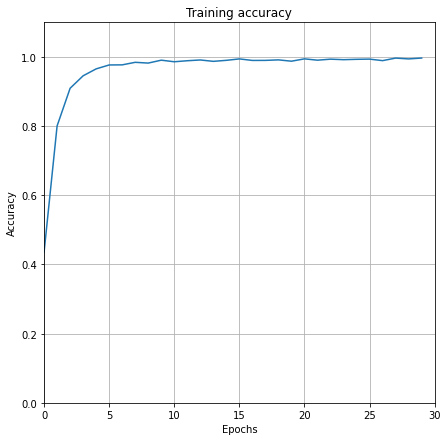

In [ ]:
plt.figure(figsize=(7,7))
plt.ylim(0,1.1)
plt.xlim(0,30)
plt.grid()
plt.plot(history.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training accuracy')
plt.show()

#testing hybrid sn

#resizing X_test to feed as input

In [ ]:
X_test = X_test.reshape(-1, window_size, window_size, number_of_components, 1)
X_test.shape

(3351, 11, 11, 20, 1)

#applying one hot encoding to y_test

In [ ]:
y_test = np_utils.to_categorical(y_test)
print(f"y_test shape after applying one hot encoding : {y_test.shape}")

y_test shape after applying one hot encoding : (3351, 16)


#predicting test dataset

In [ ]:
start = time.time()

Y_pred_test = model.predict(X_test)

end = time.time()
testing_time = end - start
print(f"Time taken for predicting test set : {str(timedelta(seconds=testing_time))}\n\n\n")


y_pred_test = np.argmax(Y_pred_test, axis=1)
y_test = np.argmax(y_test, axis=1)

Time taken for predicting test set : 0:00:04.187751





#creating confusion matrix

In [ ]:
def hybrid_sn_report(y_test,y_pred_test):
  
  class_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn',
                 'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                 'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives','Stone-Steel-Towers']

  
  y_unique=np.unique(y_pred_test)
  y_pred_test_unique=list(y_unique)
  #print(y_pred_test_unique)
  #print(np.unique(y_test))
  print(f"Number of classes predicted : {len(y_pred_test_unique)}\n")
  
  req_class_names=[]
  for i in y_unique:
    req_class_names.append(class_names[i])  
  
  print("Confusion matrix : \n")
  confusion = confusion_matrix(y_test, y_pred_test)
  annot = np.empty_like(confusion).astype(str)
  cm_sum = np.sum(confusion, axis=1, keepdims=True)
  accuracy_class = confusion / confusion.sum(axis=1) * 100
  rows, cols = confusion.shape
  for i in range(rows):
    for j in range(cols):
      c = confusion[i, j]
      p = accuracy_class[i, j]
      if i == j:
          s = cm_sum[i]
          annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
      elif c == 0:
          annot[i, j] = ''
      else:
          annot[i, j] = '%.1f%%\n%d' % (p, c)
  cm = pd.DataFrame(confusion, index=req_class_names, columns=req_class_names)
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  plt.show()
  fig, ax = plt.subplots(figsize=(25,15))
  sns.heatmap(cm, cmap= "Blues", annot=annot, fmt='', ax=ax)
  plt.show()
  
  classification = classification_report(y_pred_test, y_test, target_names=req_class_names)
  print("\nClassification report : \n")
  print(classification)
  

  accuracy = accuracy_score(y_pred_test, y_test)
  print(f"\nTesting set accuracy : {accuracy*100} %")
  
  kappa = cohen_kappa_score(y_pred_test, y_test)
  print(f"\nCohen kappa score : {kappa}\n\n\n") 

Number of classes predicted : 13

Confusion matrix : 



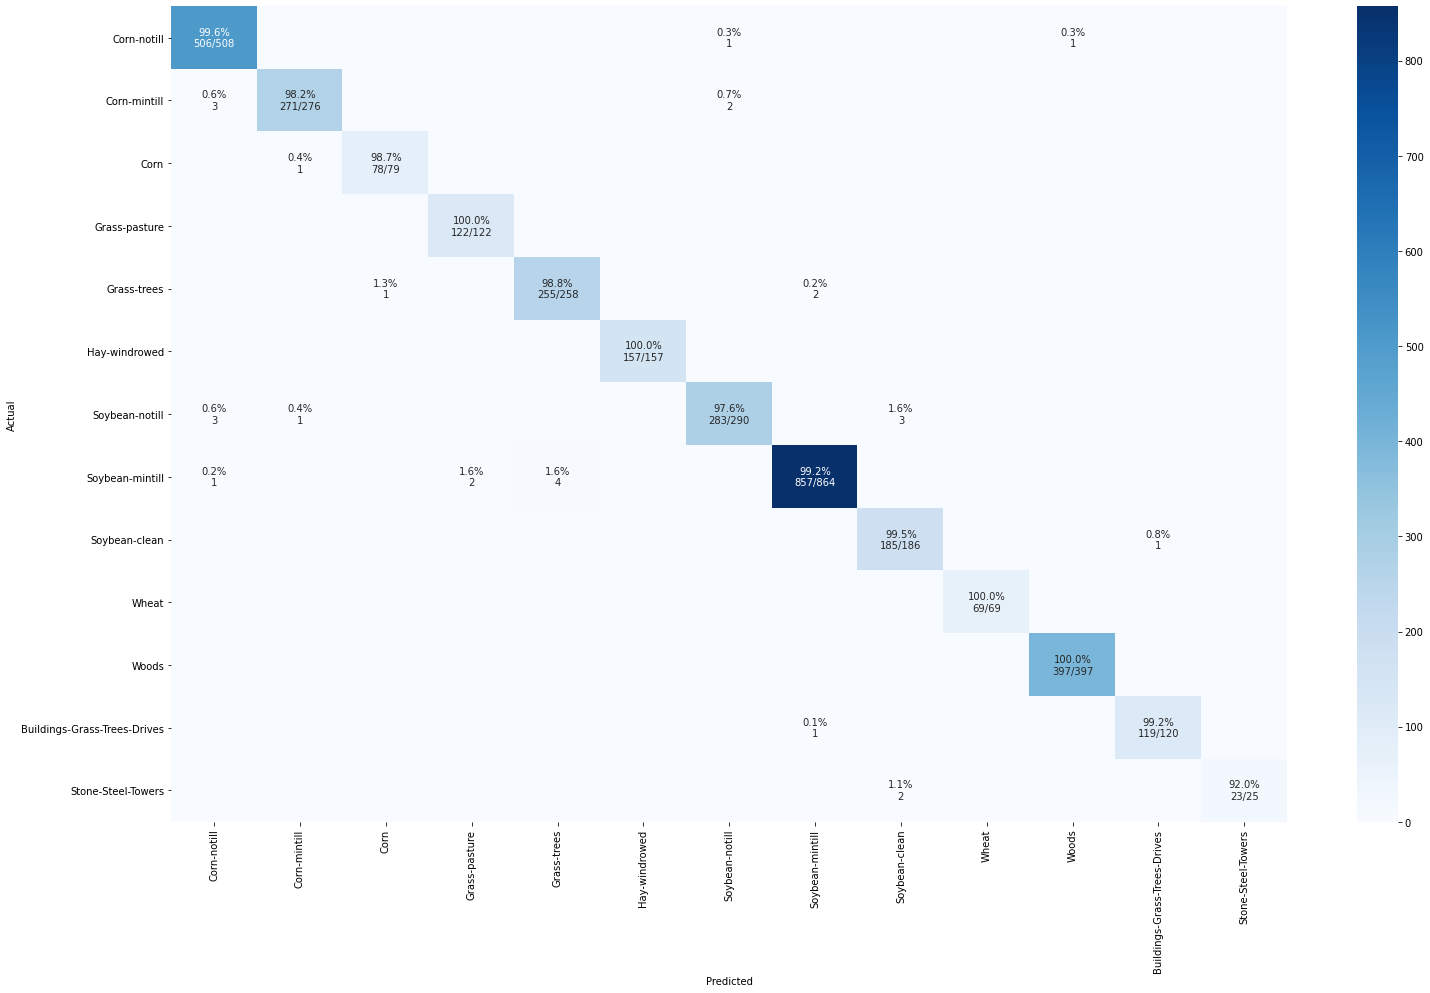


Classification report : 

                              precision    recall  f1-score   support

                 Corn-notill       1.00      0.99      0.99       513
                Corn-mintill       0.98      0.99      0.99       273
                        Corn       0.99      0.99      0.99        79
               Grass-pasture       1.00      0.98      0.99       124
                 Grass-trees       0.99      0.98      0.99       259
               Hay-windrowed       1.00      1.00      1.00       157
              Soybean-notill       0.98      0.99      0.98       286
             Soybean-mintill       0.99      1.00      0.99       860
               Soybean-clean       0.99      0.97      0.98       190
                       Wheat       1.00      1.00      1.00        69
                       Woods       1.00      1.00      1.00       398
Buildings-Grass-Trees-Drives       0.99      0.99      0.99       120
          Stone-Steel-Towers       0.92      1.00      0.96   

In [ ]:
hybrid_sn_report(y_test,y_pred_test)

#predicting the entire dataset

In [ ]:
# Load the original dataset
X, y = load_dataset()

Load dataset

X shape : (145, 145, 200)
y shape : (145, 145)





In [ ]:
X,pca = apply_pca(X, number_of_components)

Apply PCA

temp_X shape : (21025, 200)
X shape after applying PCA dimensionality reduction technique : (145, 145, 20)





In [ ]:
X = zero_padding_X(X, window_size//2)

The shape of X after zero padding : (155, 155, 20)


In [ ]:
height = y.shape[0]
width = y.shape[1]
print(height , width)


145 145


In [ ]:
def Patch(data,height_index,width_index,window_size):
    
    height_slice = slice(height_index, height_index+window_size)
    width_slice = slice(width_index, width_index+window_size)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
# calculate the predicted image
from tqdm.auto import trange

predicted_output = np.zeros((height,width))

start = time.time()

for i in trange(height, desc="Predicting image"):
    #for j in trange(width,leave=False):
    for j in range(width):
      target = int(y[i,j])
      if target == 0 :
          continue
      else :
          image_patch=Patch(X,i,j,window_size=window_size)
          X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
          prediction = (model.predict(X_test_image))
          prediction = np.argmax(prediction, axis=1)
          predicted_output[i][j] = prediction+1

end = time.time()
testing_time = end - start
print(f"Time taken for predicting entire image : {str(timedelta(seconds=testing_time))}\n\n\n")


Time taken for predicting entire image : 0:06:33.345190





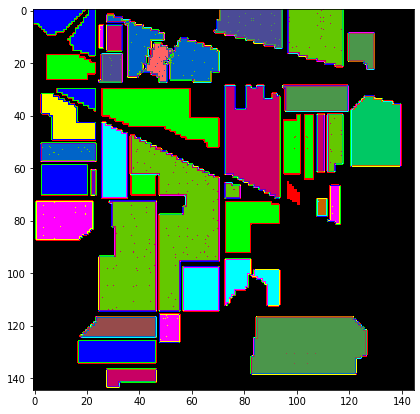

In [ ]:
# Display groundtruth image
ground_truth=spectral.imshow(classes=y,figsize=(7,7))

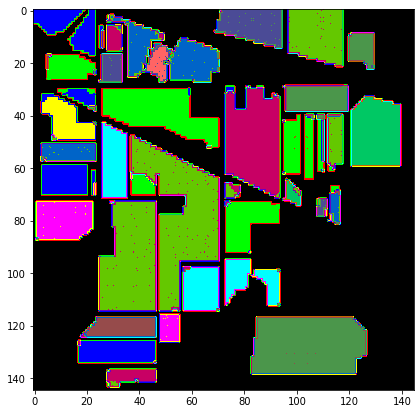

In [ ]:
# Display predicted image
predict_image = spectral.imshow(classes = predicted_output.astype(int),figsize =(7,7))

#combining code into single cell

In [ ]:
def hybrid_sn_comp(number_of_components = 20, window_size = 9, labelling_type="majority", test_ratio = 0.33 ,dropout = 0.40, epoch = 20, size =  128):

  ## Importing dataset
  X,y= load_dataset()

  
  ## Applying dimensionality reduction -  Passing number of components 20 for PCA to the function apply_pca
  X,pca = apply_pca(X,number_of_components)
  
  # Creating smaller image cuboids with a give window size
  X,y = create_image_cuboids(X,y,window_size, labelling_type=labelling_type)

  # Count the number of elements present in each class of y
  count_frequency(y,name="y")

  
  ## Splitting dataset into training and testing dataset with given test ratio
  X_train, X_test, y_train, y_test = split_dataset(X, y, test_ratio)

  # Count the number of elements present in each class of y_train and y_test
  count_frequency(y_train, name="y_train")
  count_frequency(y_test, name="y_test")
  
  
  ## Training nybrid_sn

  print("\n\n\nTrain hybrid_sn\n")

  # Reshaping X_train to feed it as input to hybrid_sn
  X_train = X_train.reshape(-1, window_size, window_size, number_of_components , 1)

  # Apply one-hot encoding to y_train
  y_train = np_utils.to_categorical(y_train)
  print(f"y_train shape after applying one hot encoding : {y_train.shape}\n\n")

  S = window_size
  L = number_of_components
  output_units = 16
  
  # Input layer
  input_layer = Input((S, S, L, 1))

  # Convolutional Layers
  conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
  conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
  conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
  conv3d_shape = conv_layer3.shape
  print(conv3d_shape)
  conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
  conv_layer4 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(conv_layer3)
  # Faltten D Convolutional Layer
  flatten_layer = Flatten()(conv_layer4)
  # Fully Connected Layers
  dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
  dense_layer1 = Dropout(dropout)(dense_layer1)
  dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
  dense_layer2 = Dropout(dropout)(dense_layer2)
  output_layer = Dense(units=16, activation='softmax')(dense_layer2)

  # Define the model with input layer and output layer
  model = Model(inputs=input_layer, outputs=output_layer)
  
  # Provides the architecture details of hybrid_sn model
  model.summary()

  # Compiling the model
  adam = Adam(lr=0.001, decay=1e-06)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  # Checkpoint
  filepath = "best-model.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  start = time.time()
  
  # Train hybrid_sn with given number of epochs, batch size and training data set
  history = model.fit(x=X_train, y=y_train, batch_size=size, epochs=epoch, callbacks=callbacks_list)

  end = time.time()
  training_time = end - start
  print(f"\nTime taken for training : {str(timedelta(seconds=training_time))}\n\n\n")

  plt.figure(figsize=(7,7))
  plt.ylim(0,1.1)
  plt.xlim(0,epoch)
  plt.grid()
  plt.plot(history.history['accuracy'])
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.title('Training accuracy')
  plt.show()
  
  
  ## Testing hybrid_sn model

  print(f"Test hybrid_sn \n")
 
  # Reshaping X_test to feed it as input to hybrid_sn 
  X_test = X_test.reshape(-1, window_size, window_size, number_of_components, 1)
  
  # Applying one-hot encoding to y_test 
  y_test = np_utils.to_categorical(y_test)
  print(f"y_test shape after applying one hot encoding : {y_test.shape}\n")
  
  start = time.time()
  
  # Predicting the testing dataset
  Y_pred_test = model.predict(X_test)
  
  end = time.time()
  testing_time = end - start
  print(f"Time taken for predicting test set : {str(timedelta(seconds=testing_time))}\n\n\n")


  ## Create classification report and confusion matrix
  
  print("hybrid_sn report\n")

  # Returns the indices of the maximmum values along an axis
  y_pred_test = np.argmax(Y_pred_test, axis=1)
  
  # Compare y_pred_test and y_test and print classification report
  classification = classification_report(np.argmax(y_test, axis=1), y_pred_test)
  print(classification)
  
  # Compare y_pred_test and y_test and print confusion matrix
  confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred_test)
  print(confusion)
  print(f"The shape of confusion matrix is : {confusion.shape}\n\n\n")
  #np.sum(confusion)

  
  ## Predicting entire dataset

  print("Predicting entire image\n")
  
  # load the original image
  X, y = load_dataset()

  height = y.shape[0]
  width = y.shape[1]

  # Applying PCA with given number of components
  X,pca = apply_pca(X, number_of_components)
  
  # Applying zero padding
  X = zero_padding_X(X, window_size//2)

  # Create a numpy array of zeros with dimensions height and width
  outputs = np.zeros((height,width))

  # Import library to display progress bar
  from tqdm.auto import trange  
  
  start = time.time()
  print("\n")
  
  for i in trange(height, desc="Predicting image"):
    for j in range(width):
      
      # Extracting labels from dataset
      target = int(y[i,j])
      
      # Predicting only for classes that are not zero
      if target == 0 :
          continue
      else :
          # Creating smaller cuboids of images 
          image_patch=Patch(X,i,j,window_size)
          
          # Resize image_patch to feed it as input to CNN model
          X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
          
          # Predict the class X_test_image belongs to
          prediction = (model.predict(X_test_image))
          
          prediction = np.argmax(prediction, axis=1)
          outputs[i][j] = prediction+1
  
  end = time.time()
  testing_time = end - start
  print(f"Time taken for predicting entire image : {str(timedelta(seconds=testing_time))}\n\n\n")
  
  

  # Display groundtruth image
  ground_truth = spectral.imshow(classes = y,figsize =(7,7))
  
  

  # Display predicted image
  predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

Load dataset

X shape : (145, 145, 200)
y shape : (145, 145)



Apply PCA

temp_X shape : (21025, 200)
X shape after applying PCA dimensionality reduction technique : (145, 145, 20)



Create smaller image cuboids

The shape of X after zero padding : (153, 153, 20)
The shape of y after zero padding : (153, 153)
Classes available for classification after removing class 0 : [ 1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 12. 13. 14. 15. 16.]
New Class labels starting from 0 :  [ 0.  1.  2.  3.  4.  5.  6.  7.  9. 10. 11. 12. 13. 14. 15.]
The shape of X_cuboids : (10329, 9, 9, 20)
The shape of y_cuboids_labels : (10329,)



Number of elements present in each class of y: {0.0: 16, 1.0: 1526, 2.0: 864, 3.0: 247, 4.0: 412, 5.0: 787, 6.0: 2, 7.0: 468, 9.0: 942, 10.0: 2590, 11.0: 579, 12.0: 214, 13.0: 1224, 14.0: 374, 15.0: 84}



Splitting Dataset

X_train shape : (6920, 9, 9, 20)
y_train shape : (6920,)
X_test shape  : (3409, 9, 9, 20)
y_test shape  : (3409,)
Number of elements present in each clas

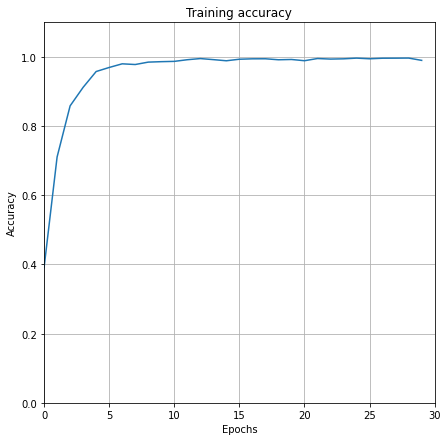

Test CNN 

y_test shape after applying one hot encoding : (3409, 16)

Time taken for predicting test set : 0:00:02.348253



CNN report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.99      0.93      0.96       504
           2       0.99      0.95      0.97       285
           3       0.96      0.93      0.94        81
           4       1.00      0.98      0.99       136
           5       0.99      0.98      0.98       260
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00       154
           9       0.99      0.98      0.99       311
          10       0.95      1.00      0.97       855
          11       0.95      0.99      0.97       191
          12       1.00      0.99      0.99        71
          13       1.00      1.00      1.00       404
          14       1.00      0.97      0.98       123
          15       0.96      0.96      0.96        2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



X shape after applying PCA dimensionality reduction technique : (145, 145, 20)



The shape of X after zero padding : (153, 153, 20)





Time taken for predicting entire image : 0:06:20.506148





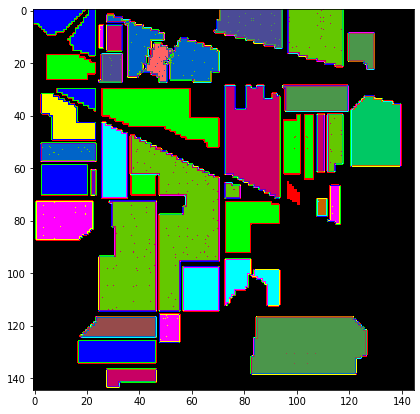

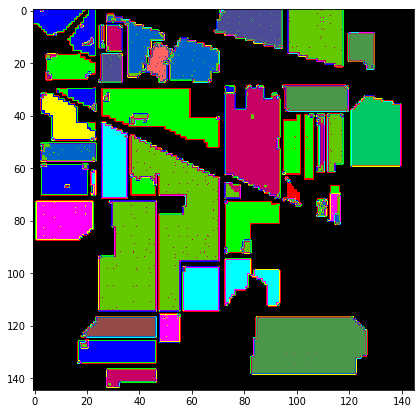

In [ ]:
hybrid_sn_comp(number_of_components = 20, window_size = 9, labelling_type="majority", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

Load dataset

X shape : (145, 145, 200)
y shape : (145, 145)



Apply PCA

temp_X shape : (21025, 200)
X shape after applying PCA dimensionality reduction technique : (145, 145, 20)



Create smaller image cuboids

The shape of X after zero padding : (153, 153, 20)
The shape of y after zero padding : (153, 153)
Classes available for classification after removing class 0 : [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
New Class labels starting from 0 :  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
The shape of X_cuboids : (10249, 9, 9, 20)
The shape of y_cuboids_labels : (10249,)



Number of elements present in each class of y: {0.0: 46, 1.0: 1428, 2.0: 830, 3.0: 237, 4.0: 483, 5.0: 730, 6.0: 28, 7.0: 478, 8.0: 20, 9.0: 972, 10.0: 2455, 11.0: 593, 12.0: 205, 13.0: 1265, 14.0: 386, 15.0: 93}



Splitting Dataset

X_train shape : (6866, 9, 9, 20)
y_train shape : (6866,)
X_test shape  : (3383, 9, 9, 20)
y_test shape  : (3383,)
Number of elements pr

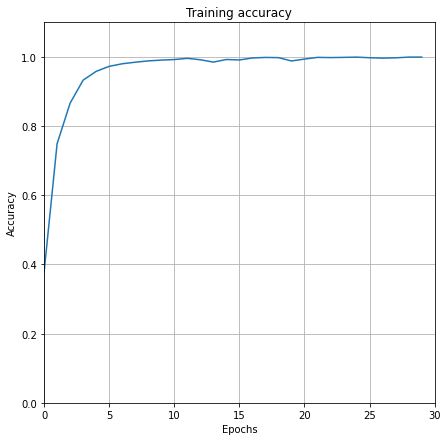

Test CNN 

y_test shape after applying one hot encoding : (3383, 16)

Time taken for predicting test set : 0:00:02.233010



CNN report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00       471
           2       1.00      1.00      1.00       274
           3       0.97      1.00      0.99        78
           4       1.00      0.99      0.99       159
           5       1.00      1.00      1.00       241
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00       158
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00       321
          10       1.00      1.00      1.00       810
          11       1.00      1.00      1.00       196
          12       1.00      1.00      1.00        68
          13       1.00      1.00      1.00       418
          14       0.99      0.99      0.99       12


Time taken for predicting entire image : 0:06:23.401733





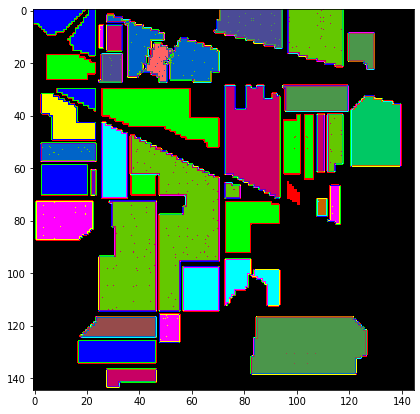

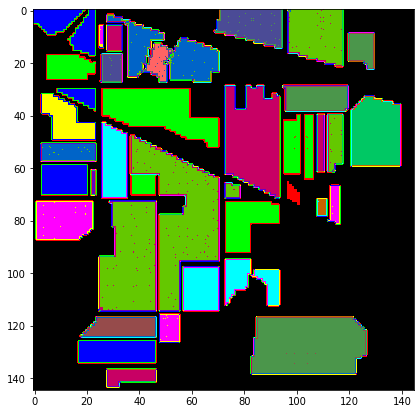

In [ ]:
hybrid_sn_comp(number_of_components = 20, window_size = 9, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

#different window size

In [ ]:
def hybrid_sn(number_of_components = 20, window_size = 9, labelling_type="majority", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128):

  ## Importing dataset
  X,y= load_dataset()

  
  ## Applying dimensionality reduction -  Passing number of components 20 for PCA to the function apply_pca
  X,pca = apply_pca(X,number_of_components)
  
  # Creating smaller image cuboids with a give window size
  X,y = create_image_cuboids(X,y,window_size, labelling_type=labelling_type)

  # Count the number of elements present in each class of y
  count_frequency(y,name="y")

  
  ## Splitting dataset into training and testing dataset with given test ratio
  X_train, X_test, y_train, y_test = split_dataset(X, y, test_ratio)

  # Count the number of elements present in each class of y_train and y_test
  count_frequency(y_train, name="y_train")
  count_frequency(y_test, name="y_test")
  
  
  ## Training hybrid_sn

  print("\n\n\nTrain hybrid_sn\n")

  # Reshaping X_train to feed it as input to CNN
  X_train = X_train.reshape(-1, window_size, window_size, number_of_components , 1)

  # Apply one-hot encoding to y_train
  y_train = np_utils.to_categorical(y_train)
  print(f"y_train shape after applying one hot encoding : {y_train.shape}\n\n")

  S = window_size
  L = number_of_components
  output_units = 16
  
  # Input layer
  input_layer = Input((S, S, L, 1))

  # 3D Convolutional Layers
  conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
  conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
  conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
  conv3d_shape = conv_layer3.shape
  print(conv3d_shape)
  conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
  conv_layer4 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(conv_layer3)
  # Faltten Convolutional Layer
  flatten_layer = Flatten()(conv_layer4)
  # Fully Connected Layers
  dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
  dense_layer1 = Dropout(dropout)(dense_layer1)
  dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
  dense_layer2 = Dropout(dropout)(dense_layer2)
  output_layer = Dense(units=16, activation='softmax')(dense_layer2)

  # Define the model with input layer and output layer
  model = Model(inputs=input_layer, outputs=output_layer)
  
  # Provides the architecture details of CNN model
  model.summary()

  # Compiling the model
  adam = Adam(lr=0.001, decay=1e-06)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  # Checkpoint
  filepath = "best-model.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  start = time.time()
  
  # Train CNN with given number of epochs, batch size and training data set
  history = model.fit(x=X_train, y=y_train, batch_size=size, epochs=epoch, callbacks=callbacks_list)

  end = time.time()
  training_time = end - start
  print(f"\nTime taken for training hybrid_sn : {str(timedelta(seconds=training_time))}\n")

  plt.figure(figsize=(7,7))
  plt.ylim(0,1.1)
  plt.xlim(0,epoch)
  plt.grid()
  plt.plot(history.history['accuracy'])
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.title('Training accuracy')
  plt.show()



  ## Testing hybrid_sn model

  print(f"\n\n\nTest hybrid_sn \n")
 
  # Reshaping X_test to feed it as input to hybrid_sn
  X_test = X_test.reshape(-1, window_size, window_size, number_of_components, 1)
  
  # Applying one-hot encoding to y_test 
  y_test = np_utils.to_categorical(y_test)
  print(f"y_test shape after applying one hot encoding : {y_test.shape}\n")
  
  start = time.time()
  
  # Predicting the testing dataset
  Y_pred_test = model.predict(X_test)
  
  end = time.time()
  testing_time = end - start
  print(f"Time taken for predicting test set : {str(timedelta(seconds=testing_time))}\n\n\n")


  ## Create classification report and confusion matrix
  
  print("Testing set CNN report\n")

  # Returns the indices of the maximmum values along an axis
  y_pred_test = np.argmax(Y_pred_test, axis=1)
  y_test = np.argmax(y_test, axis=1)
  
  
  hybrid_sn_report(y_test,y_pred_test)
  

  
  ## Predicting entire dataset

  print("Predicting entire image\n")
  
  # load the original image
  X, y = load_dataset()

  height = y.shape[0]
  width = y.shape[1]

  # Applying PCA with given number of components
  X,pca = apply_pca(X, number_of_components)
  
  # Applying zero padding
  X = zero_padding_X(X, window_size//2)

  # Create a numpy array of zeros with dimensions height and width
  predicted_output = np.zeros((height,width))

  # Import library to display progress bar
  from tqdm.auto import trange  
  
  start = time.time()
  print("\n")
  
  for i in trange(height, desc="Predicting image"):
    for j in range(width):
      
      # Extracting labels from dataset
      target = int(y[i,j])
      
      # Predicting only for classes that are not zero
      if target == 0 :
          continue
      else :
          # Creating smaller cuboids of images 
          image_patch=Patch(X,i,j,window_size)
          
          # Resize image_patch to feed it as input to CNN model
          X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
          
          # Predict the class X_test_image belongs to
          prediction = (model.predict(X_test_image))
          
          prediction = np.argmax(prediction, axis=1)
          predicted_output[i][j] = prediction+1
  
  end = time.time()
  testing_time = end - start
  print(f"Time taken for predicting entire image : {str(timedelta(seconds=testing_time))}\n\n\n")
  
 
  # Display groundtruth image
  ground_truth = spectral.imshow(classes = y,figsize =(7,7))
  plt.show()
  
  
  
  # Display predicted image
  predict_image = spectral.imshow(classes = predicted_output.astype(int),figsize =(7,7))
  plt.show()
  
  
  print("\n\n\nhybrid_sn report for predicting entire dataset\n")
  
  y_actual=np.ravel(y).astype(int)
  y_predicted = np.ravel(predicted_output).astype(int)
  y_predicted=y_predicted[y_predicted>0]
  y_actual=y_actual[y_actual>0]
  y_predicted-=1
  y_actual-=1
  #print(y_actual.shape)
  #print(y_predicted.shape)
  #print(np.unique(y_actual))
  #print(np.unique(y_predicted))

  hybrid_sn_report(y_actual,y_predicted)

Load dataset

X shape : (145, 145, 200)
y shape : (145, 145)



Apply PCA

temp_X shape : (21025, 200)
X shape after applying PCA dimensionality reduction technique : (145, 145, 20)



Create smaller image cuboids

The shape of X after zero padding : (153, 153, 20)
The shape of y after zero padding : (153, 153)
Classes available for classification after removing class 0 : [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
New Class labels starting from 0 :  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
The shape of X_cuboids : (10249, 9, 9, 20)
The shape of y_cuboids_labels : (10249,)



Number of elements present in each class of y: {0.0: 46, 1.0: 1428, 2.0: 830, 3.0: 237, 4.0: 483, 5.0: 730, 6.0: 28, 7.0: 478, 8.0: 20, 9.0: 972, 10.0: 2455, 11.0: 593, 12.0: 205, 13.0: 1265, 14.0: 386, 15.0: 93}



Splitting Dataset

X_train shape : (6866, 9, 9, 20)
y_train shape : (6866,)
X_test shape  : (3383, 9, 9, 20)
y_test shape  : (3383,)
Number of elements pr

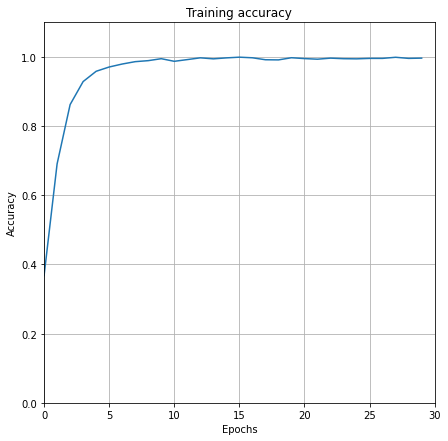




Test hybrid_sn 

y_test shape after applying one hot encoding : (3383, 16)

Time taken for predicting test set : 0:00:02.573049



Testing set CNN report

Number of classes predicted : 16

Confusion matrix : 



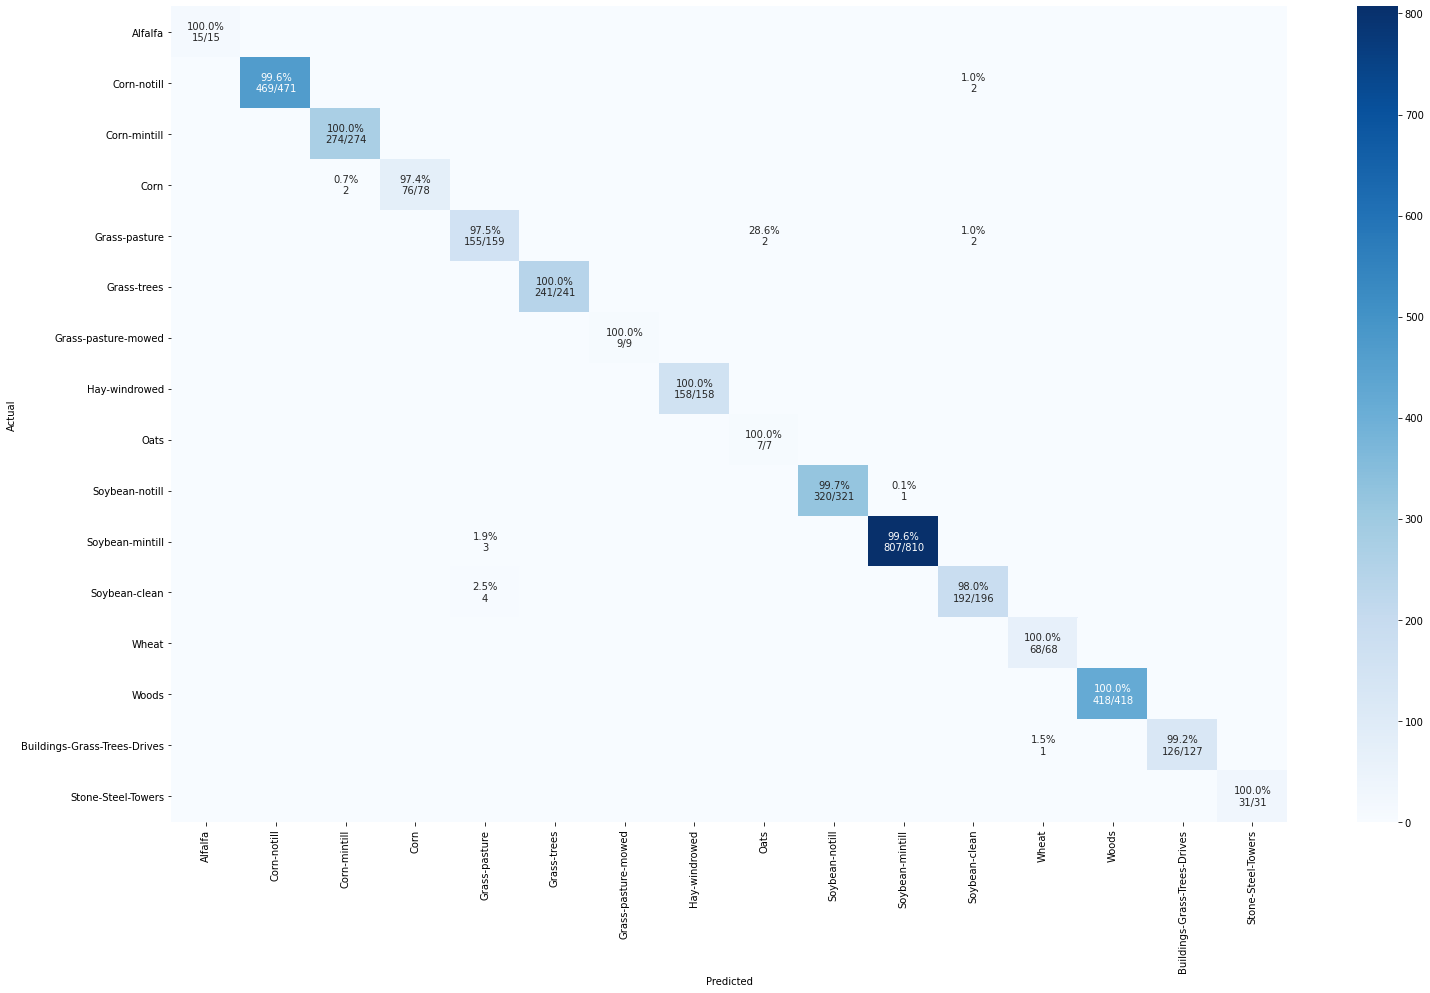


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        15
                 Corn-notill       1.00      1.00      1.00       469
                Corn-mintill       1.00      0.99      1.00       276
                        Corn       0.97      1.00      0.99        76
               Grass-pasture       0.97      0.96      0.97       162
                 Grass-trees       1.00      1.00      1.00       241
         Grass-pasture-mowed       1.00      1.00      1.00         9
               Hay-windrowed       1.00      1.00      1.00       158
                        Oats       1.00      0.78      0.88         9
              Soybean-notill       1.00      1.00      1.00       320
             Soybean-mintill       1.00      1.00      1.00       808
               Soybean-clean       0.98      0.98      0.98       196
                       Wheat       1.00      0.99      0.99   


Time taken for predicting entire image : 0:08:11.110934





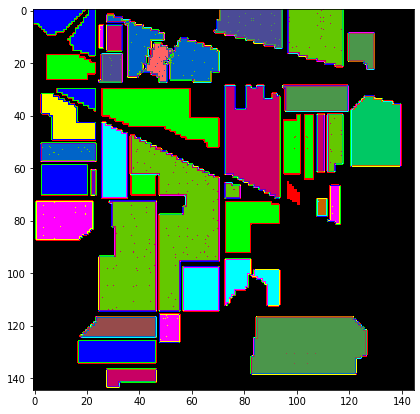

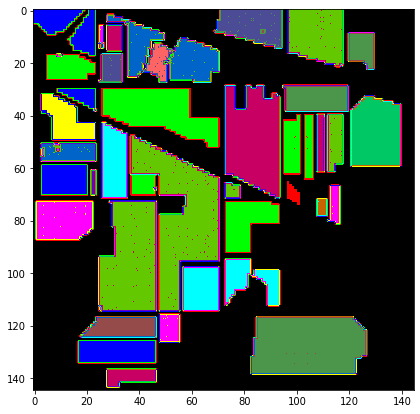




hybrid_sn report for predicting entire dataset

Number of classes predicted : 16

Confusion matrix : 



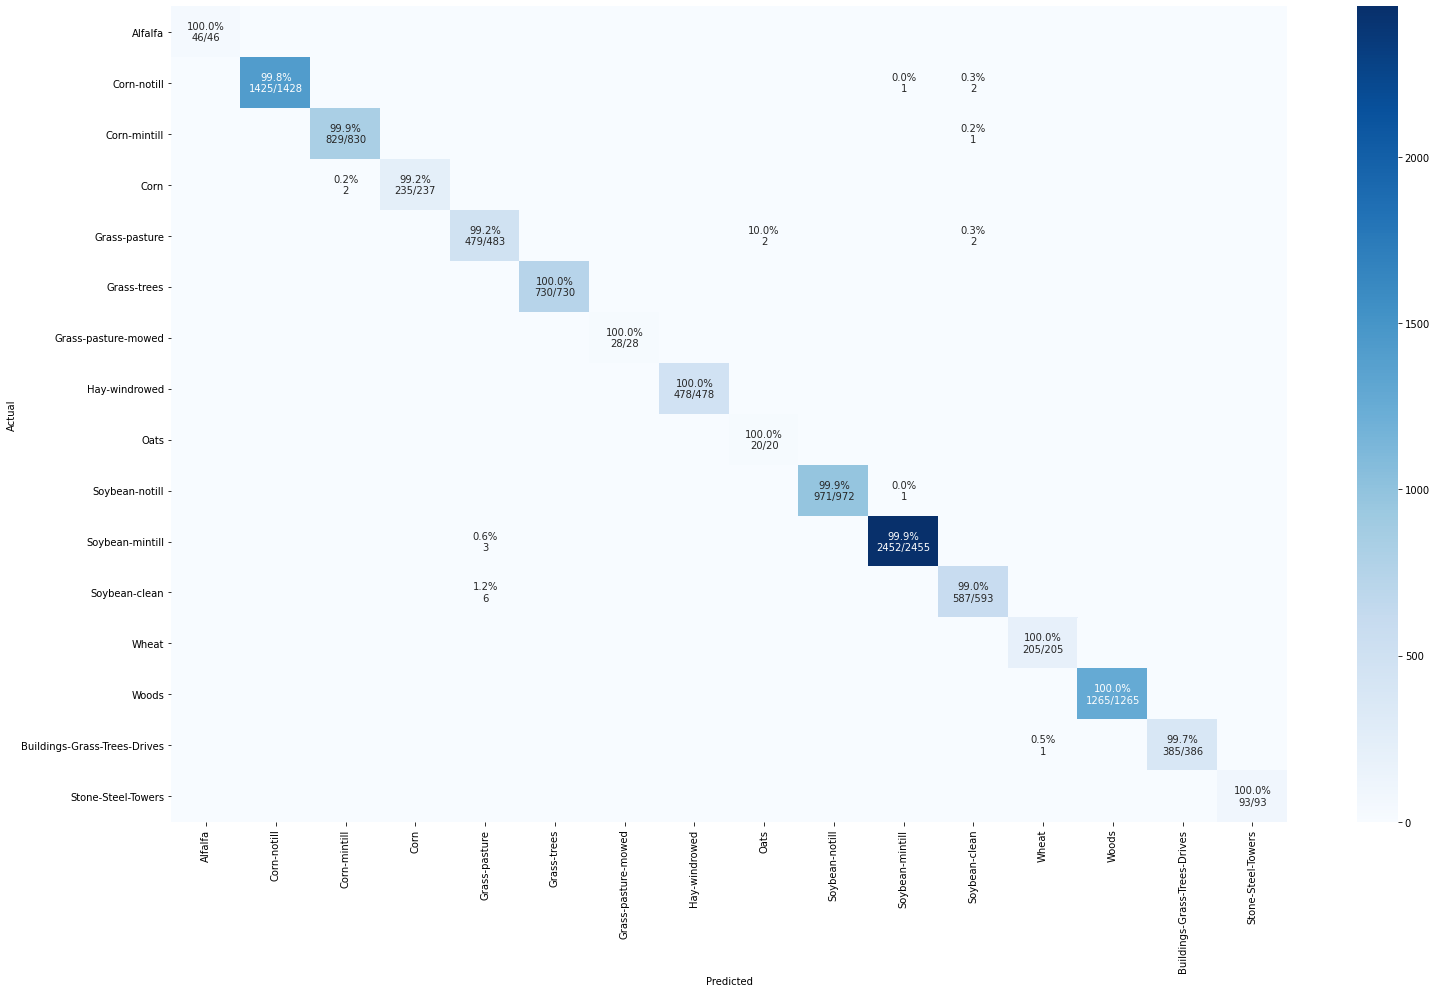


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        46
                 Corn-notill       1.00      1.00      1.00      1425
                Corn-mintill       1.00      1.00      1.00       831
                        Corn       0.99      1.00      1.00       235
               Grass-pasture       0.99      0.98      0.99       488
                 Grass-trees       1.00      1.00      1.00       730
         Grass-pasture-mowed       1.00      1.00      1.00        28
               Hay-windrowed       1.00      1.00      1.00       478
                        Oats       1.00      0.91      0.95        22
              Soybean-notill       1.00      1.00      1.00       971
             Soybean-mintill       1.00      1.00      1.00      2454
               Soybean-clean       0.99      0.99      0.99       592
                       Wheat       1.00      1.00      1.00   

In [ ]:
hybrid_sn(number_of_components = 20, window_size = 9, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

Load dataset

X shape : (145, 145, 200)
y shape : (145, 145)



Apply PCA

temp_X shape : (21025, 200)
X shape after applying PCA dimensionality reduction technique : (145, 145, 20)



Create smaller image cuboids

The shape of X after zero padding : (155, 155, 20)
The shape of y after zero padding : (155, 155)
Classes available for classification after removing class 0 : [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
New Class labels starting from 0 :  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
The shape of X_cuboids : (10249, 11, 11, 20)
The shape of y_cuboids_labels : (10249,)



Number of elements present in each class of y: {0.0: 46, 1.0: 1428, 2.0: 830, 3.0: 237, 4.0: 483, 5.0: 730, 6.0: 28, 7.0: 478, 8.0: 20, 9.0: 972, 10.0: 2455, 11.0: 593, 12.0: 205, 13.0: 1265, 14.0: 386, 15.0: 93}



Splitting Dataset

X_train shape : (6866, 11, 11, 20)
y_train shape : (6866,)
X_test shape  : (3383, 11, 11, 20)
y_test shape  : (3383,)
Number of eleme

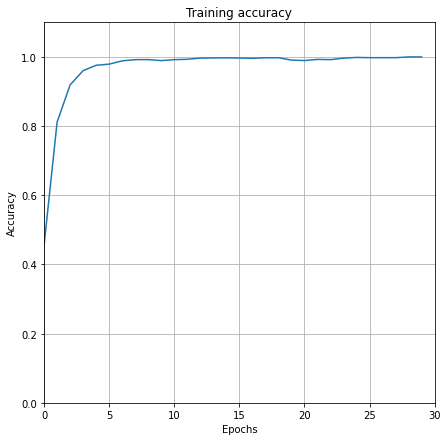




Test hybrid_sn 

y_test shape after applying one hot encoding : (3383, 16)

Time taken for predicting test set : 0:00:04.384300



Testing set CNN report

Number of classes predicted : 16

Confusion matrix : 



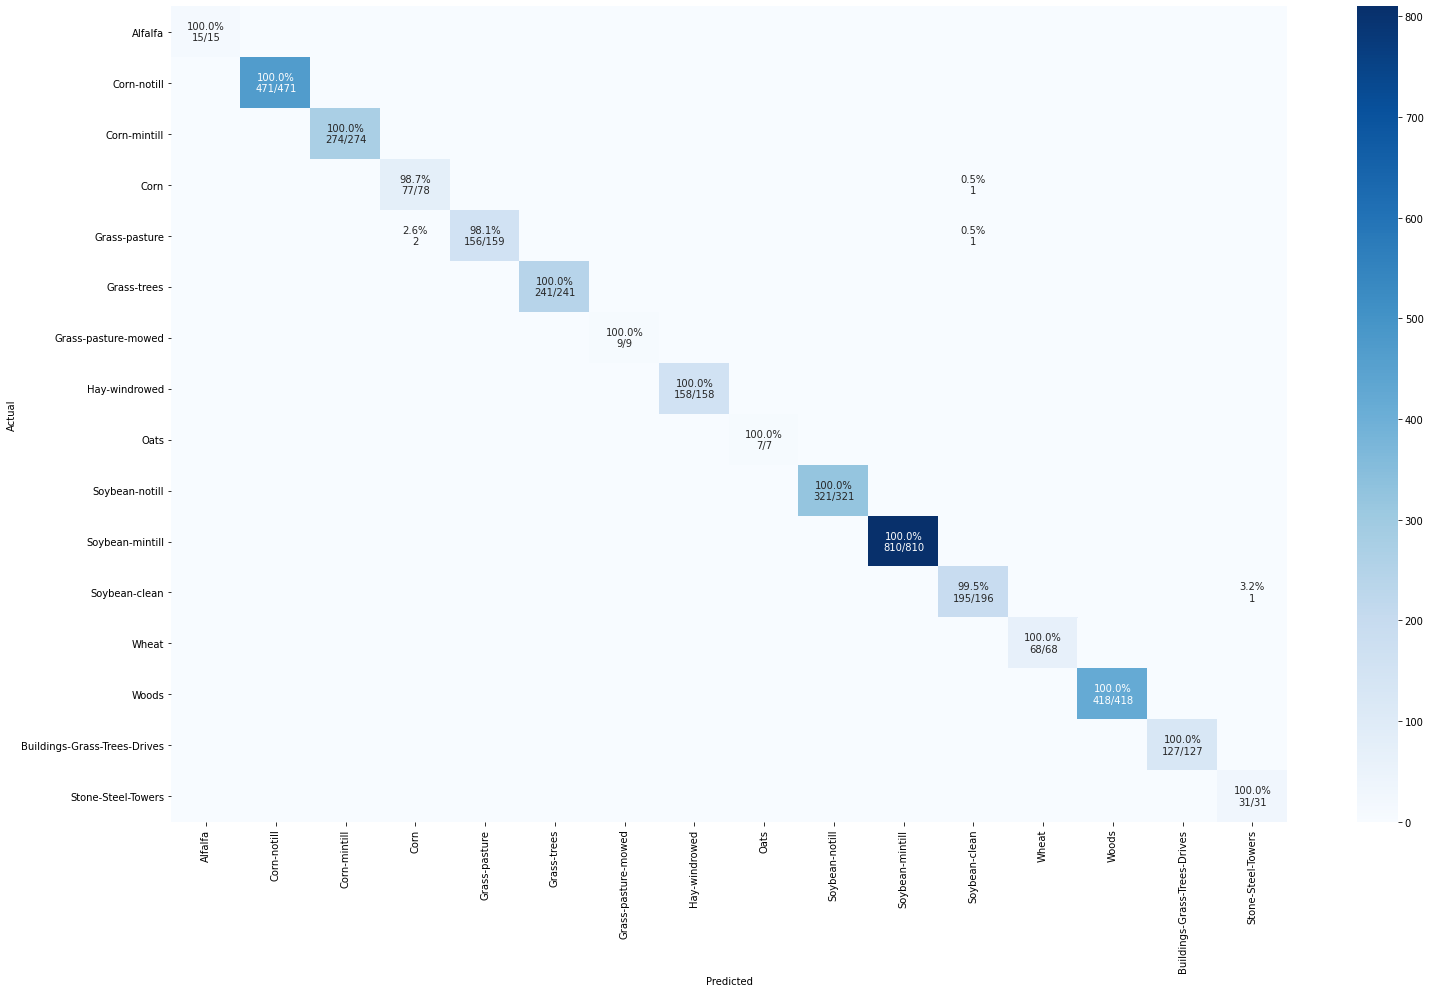


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        15
                 Corn-notill       1.00      1.00      1.00       471
                Corn-mintill       1.00      1.00      1.00       274
                        Corn       0.99      0.97      0.98        79
               Grass-pasture       0.98      1.00      0.99       156
                 Grass-trees       1.00      1.00      1.00       241
         Grass-pasture-mowed       1.00      1.00      1.00         9
               Hay-windrowed       1.00      1.00      1.00       158
                        Oats       1.00      1.00      1.00         7
              Soybean-notill       1.00      1.00      1.00       321
             Soybean-mintill       1.00      1.00      1.00       810
               Soybean-clean       0.99      0.99      0.99       197
                       Wheat       1.00      1.00      1.00   


Time taken for predicting entire image : 0:06:28.484536





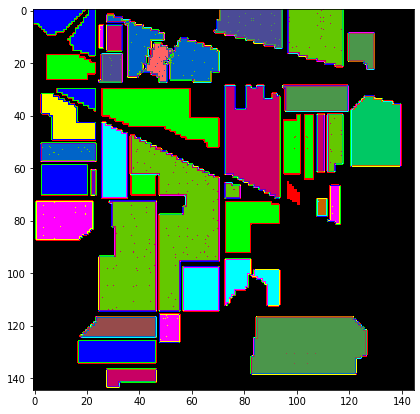

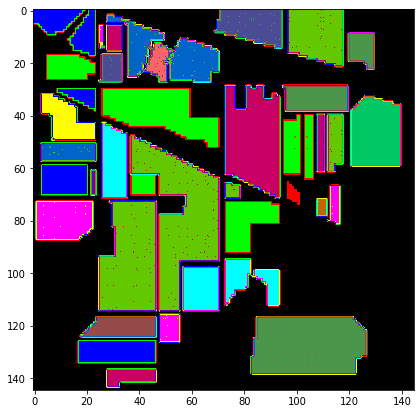




hybrid_sn report for predicting entire dataset

Number of classes predicted : 16

Confusion matrix : 



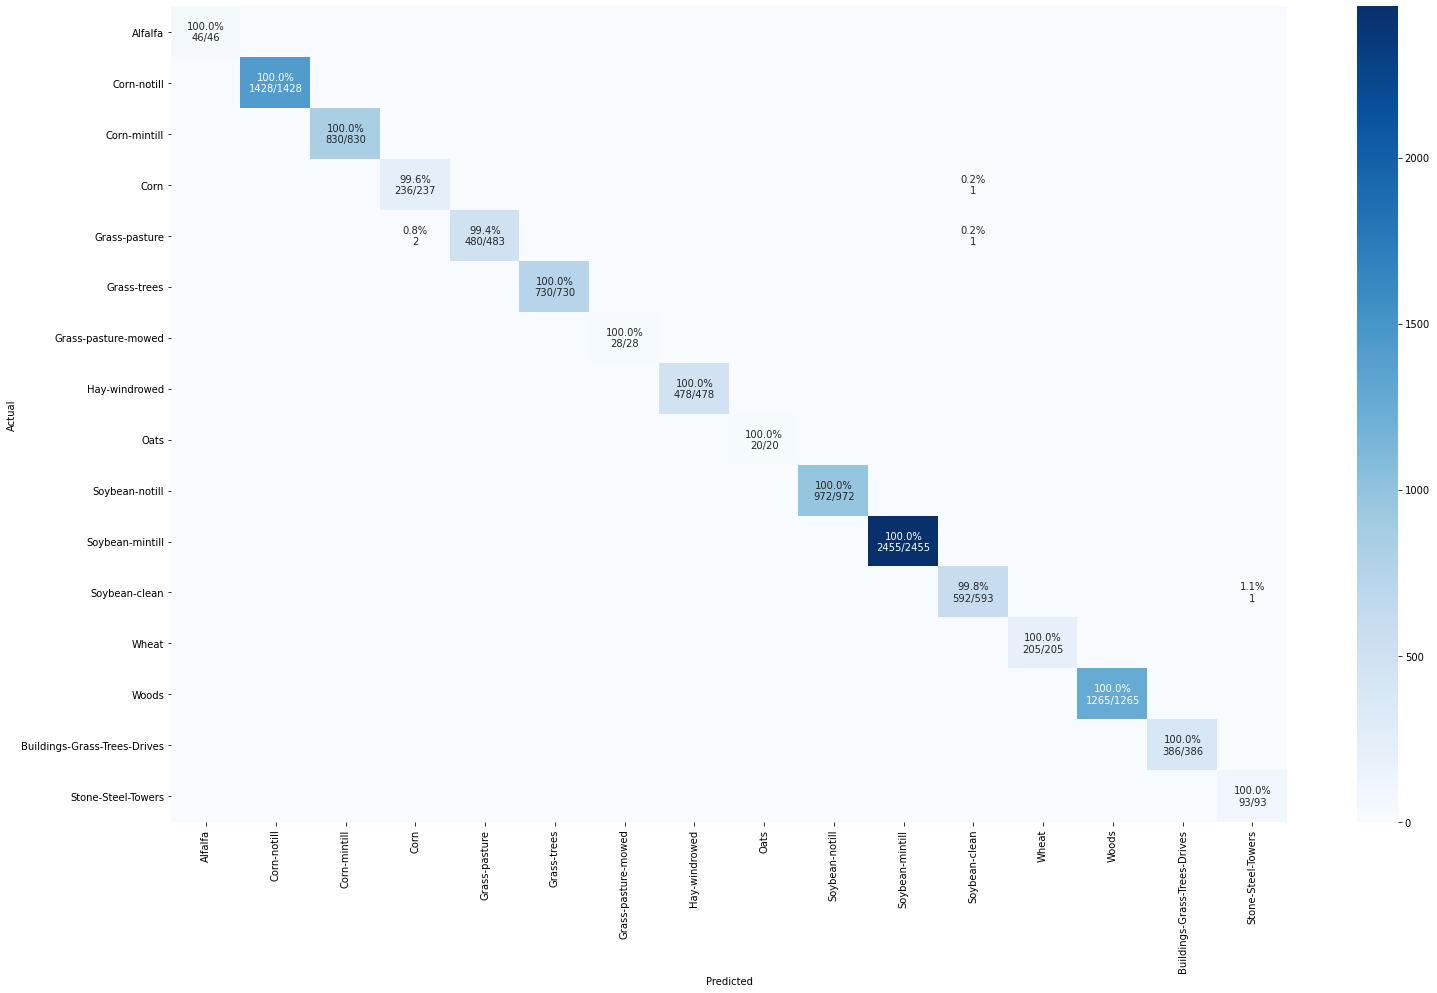


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        46
                 Corn-notill       1.00      1.00      1.00      1428
                Corn-mintill       1.00      1.00      1.00       830
                        Corn       1.00      0.99      0.99       238
               Grass-pasture       0.99      1.00      1.00       480
                 Grass-trees       1.00      1.00      1.00       730
         Grass-pasture-mowed       1.00      1.00      1.00        28
               Hay-windrowed       1.00      1.00      1.00       478
                        Oats       1.00      1.00      1.00        20
              Soybean-notill       1.00      1.00      1.00       972
             Soybean-mintill       1.00      1.00      1.00      2455
               Soybean-clean       1.00      1.00      1.00       594
                       Wheat       1.00      1.00      1.00   

In [ ]:
hybrid_sn(number_of_components = 20, window_size = 11, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

Load dataset

X shape : (145, 145, 200)
y shape : (145, 145)



Apply PCA

temp_X shape : (21025, 200)
X shape after applying PCA dimensionality reduction technique : (145, 145, 20)



Create smaller image cuboids

The shape of X after zero padding : (157, 157, 20)
The shape of y after zero padding : (157, 157)
Classes available for classification after removing class 0 : [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
New Class labels starting from 0 :  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
The shape of X_cuboids : (10249, 13, 13, 20)
The shape of y_cuboids_labels : (10249,)



Number of elements present in each class of y: {0.0: 46, 1.0: 1428, 2.0: 830, 3.0: 237, 4.0: 483, 5.0: 730, 6.0: 28, 7.0: 478, 8.0: 20, 9.0: 972, 10.0: 2455, 11.0: 593, 12.0: 205, 13.0: 1265, 14.0: 386, 15.0: 93}



Splitting Dataset

X_train shape : (6866, 13, 13, 20)
y_train shape : (6866,)
X_test shape  : (3383, 13, 13, 20)
y_test shape  : (3383,)
Number of eleme

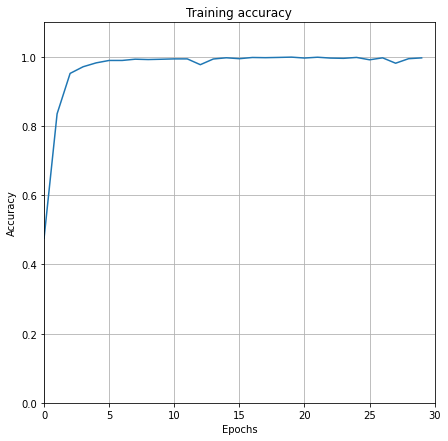




Test hybrid_sn 

y_test shape after applying one hot encoding : (3383, 16)

Time taken for predicting test set : 0:00:06.875324



Testing set CNN report

Number of classes predicted : 16

Confusion matrix : 



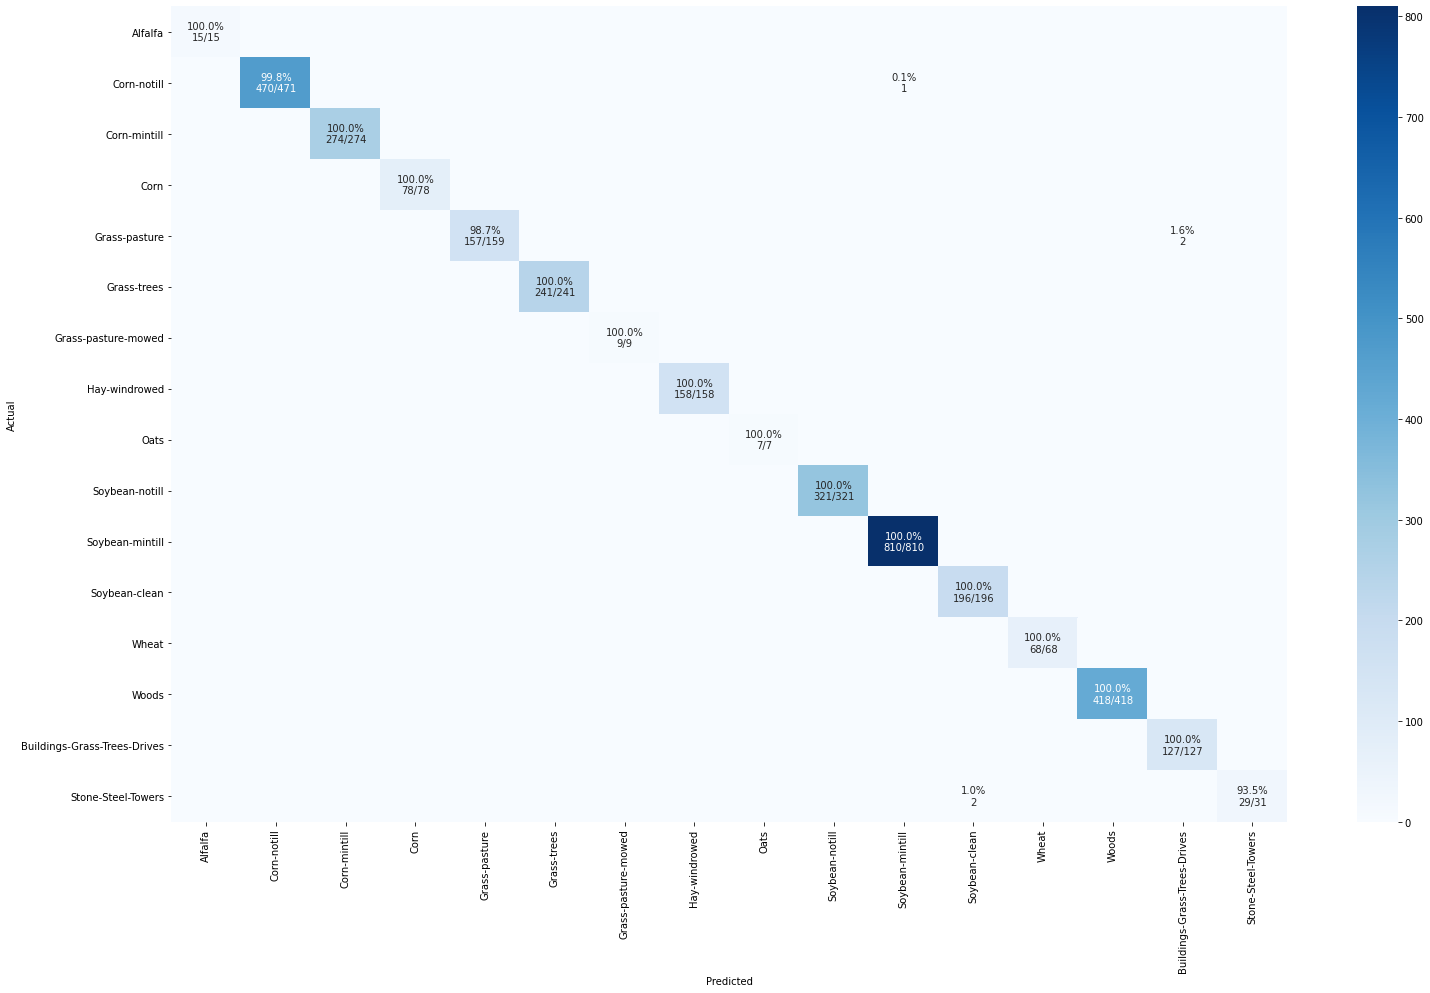


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        15
                 Corn-notill       1.00      1.00      1.00       470
                Corn-mintill       1.00      1.00      1.00       274
                        Corn       1.00      1.00      1.00        78
               Grass-pasture       0.99      1.00      0.99       157
                 Grass-trees       1.00      1.00      1.00       241
         Grass-pasture-mowed       1.00      1.00      1.00         9
               Hay-windrowed       1.00      1.00      1.00       158
                        Oats       1.00      1.00      1.00         7
              Soybean-notill       1.00      1.00      1.00       321
             Soybean-mintill       1.00      1.00      1.00       811
               Soybean-clean       1.00      0.99      0.99       198
                       Wheat       1.00      1.00      1.00   


Time taken for predicting entire image : 0:08:35.324985





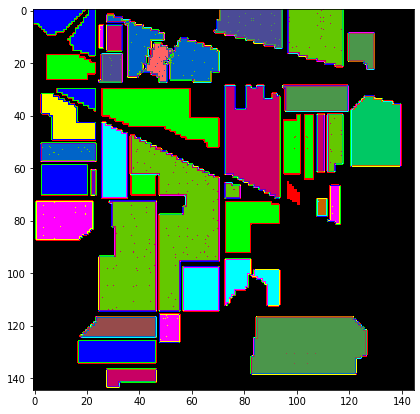

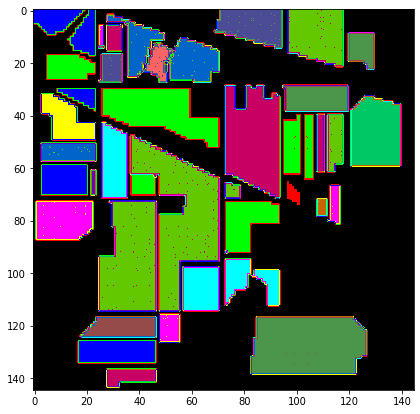




hybrid_sn report for predicting entire dataset

Number of classes predicted : 16

Confusion matrix : 



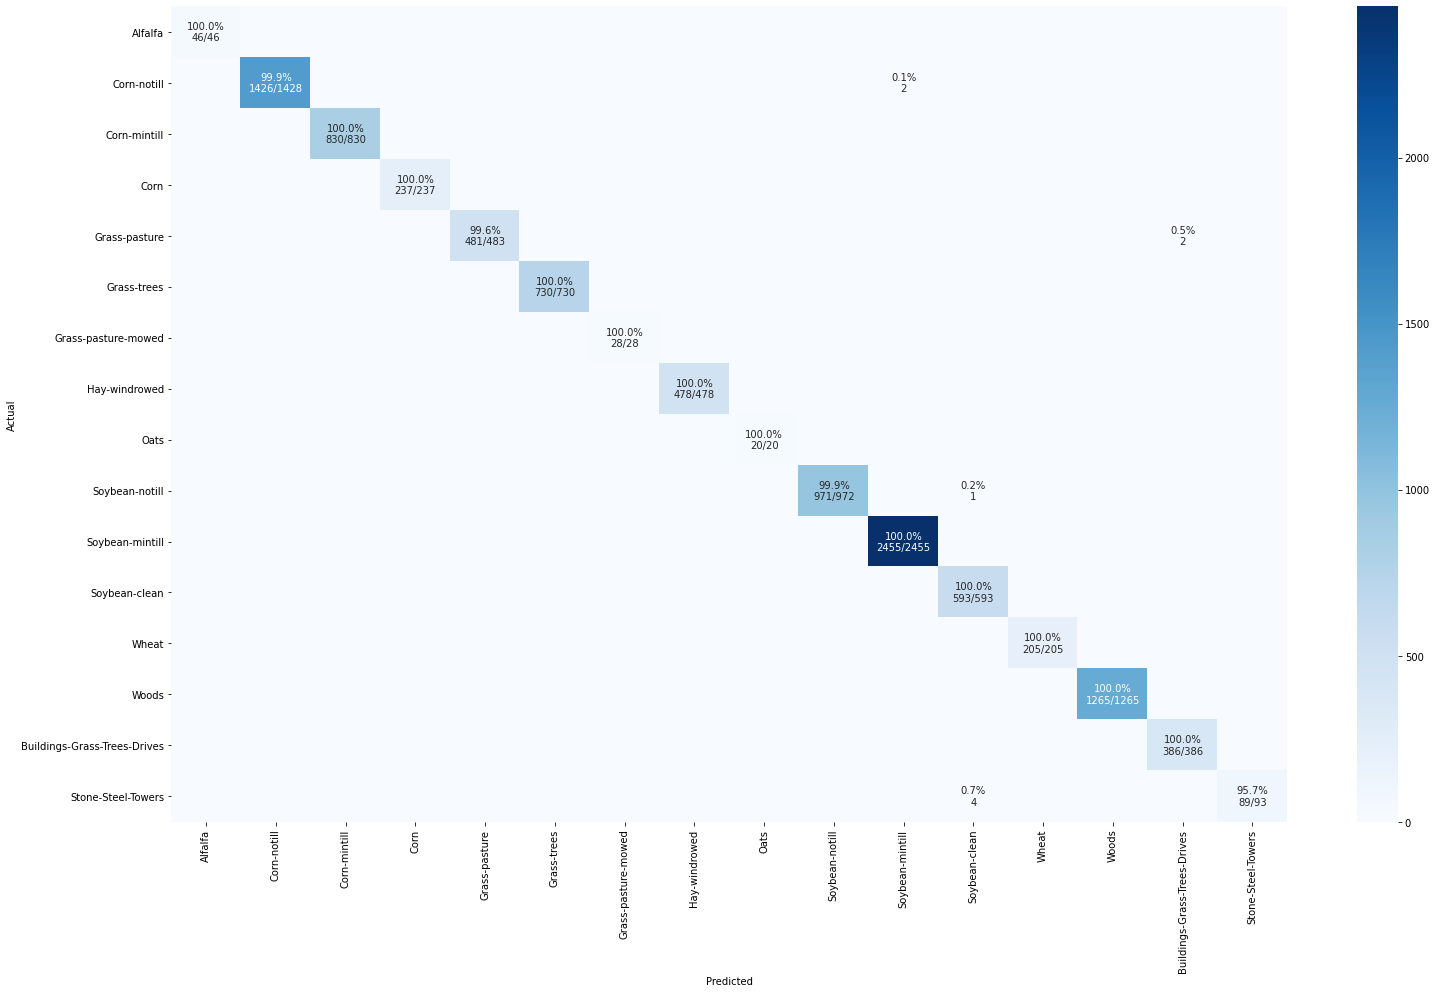


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        46
                 Corn-notill       1.00      1.00      1.00      1426
                Corn-mintill       1.00      1.00      1.00       830
                        Corn       1.00      1.00      1.00       237
               Grass-pasture       1.00      1.00      1.00       481
                 Grass-trees       1.00      1.00      1.00       730
         Grass-pasture-mowed       1.00      1.00      1.00        28
               Hay-windrowed       1.00      1.00      1.00       478
                        Oats       1.00      1.00      1.00        20
              Soybean-notill       1.00      1.00      1.00       971
             Soybean-mintill       1.00      1.00      1.00      2457
               Soybean-clean       1.00      0.99      1.00       598
                       Wheat       1.00      1.00      1.00   

In [ ]:
hybrid_sn(number_of_components = 20, window_size = 13, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

Load dataset

X shape : (145, 145, 200)
y shape : (145, 145)



Apply PCA

temp_X shape : (21025, 200)
X shape after applying PCA dimensionality reduction technique : (145, 145, 20)



Create smaller image cuboids

The shape of X after zero padding : (159, 159, 20)
The shape of y after zero padding : (159, 159)
Classes available for classification after removing class 0 : [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
New Class labels starting from 0 :  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
The shape of X_cuboids : (10249, 15, 15, 20)
The shape of y_cuboids_labels : (10249,)



Number of elements present in each class of y: {0.0: 46, 1.0: 1428, 2.0: 830, 3.0: 237, 4.0: 483, 5.0: 730, 6.0: 28, 7.0: 478, 8.0: 20, 9.0: 972, 10.0: 2455, 11.0: 593, 12.0: 205, 13.0: 1265, 14.0: 386, 15.0: 93}



Splitting Dataset

X_train shape : (6866, 15, 15, 20)
y_train shape : (6866,)
X_test shape  : (3383, 15, 15, 20)
y_test shape  : (3383,)
Number of eleme

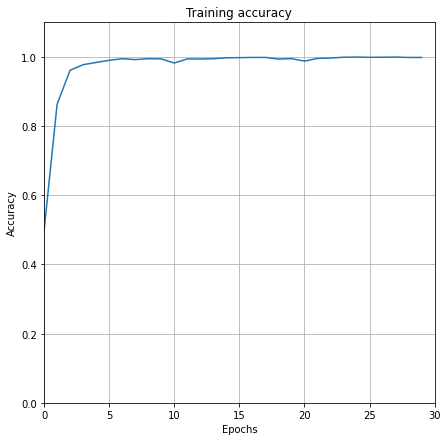




Test hybrid_sn 

y_test shape after applying one hot encoding : (3383, 16)

Time taken for predicting test set : 0:00:10.488218



Testing set CNN report

Number of classes predicted : 16

Confusion matrix : 



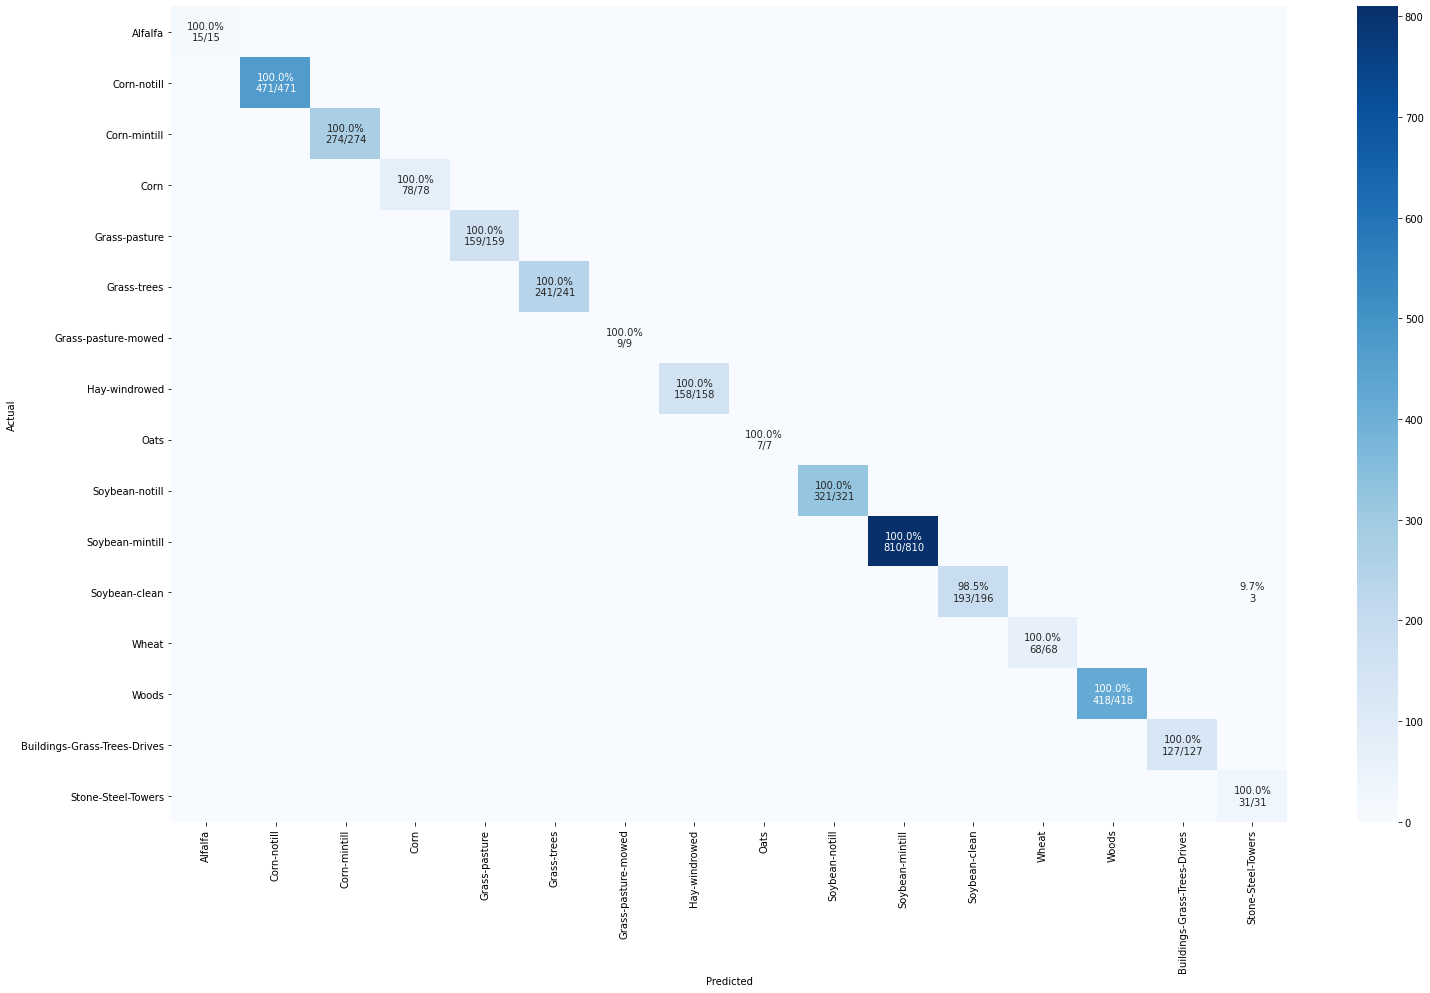


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        15
                 Corn-notill       1.00      1.00      1.00       471
                Corn-mintill       1.00      1.00      1.00       274
                        Corn       1.00      1.00      1.00        78
               Grass-pasture       1.00      1.00      1.00       159
                 Grass-trees       1.00      1.00      1.00       241
         Grass-pasture-mowed       1.00      1.00      1.00         9
               Hay-windrowed       1.00      1.00      1.00       158
                        Oats       1.00      1.00      1.00         7
              Soybean-notill       1.00      1.00      1.00       321
             Soybean-mintill       1.00      1.00      1.00       810
               Soybean-clean       0.98      1.00      0.99       193
                       Wheat       1.00      1.00      1.00   


Time taken for predicting entire image : 0:09:22.366117





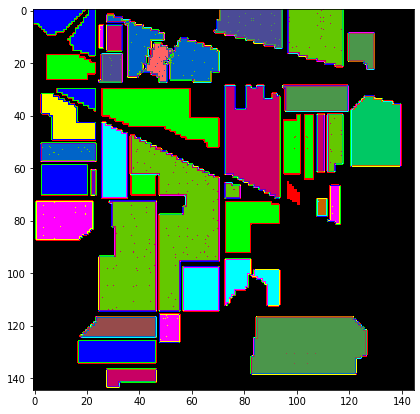

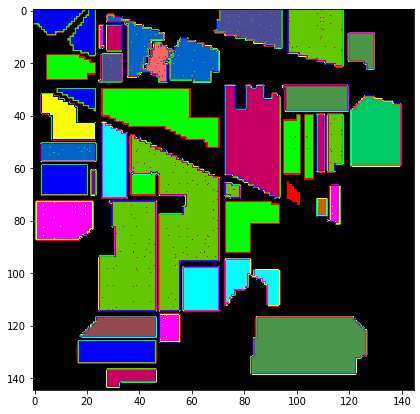




hybrid_sn report for predicting entire dataset

Number of classes predicted : 16

Confusion matrix : 



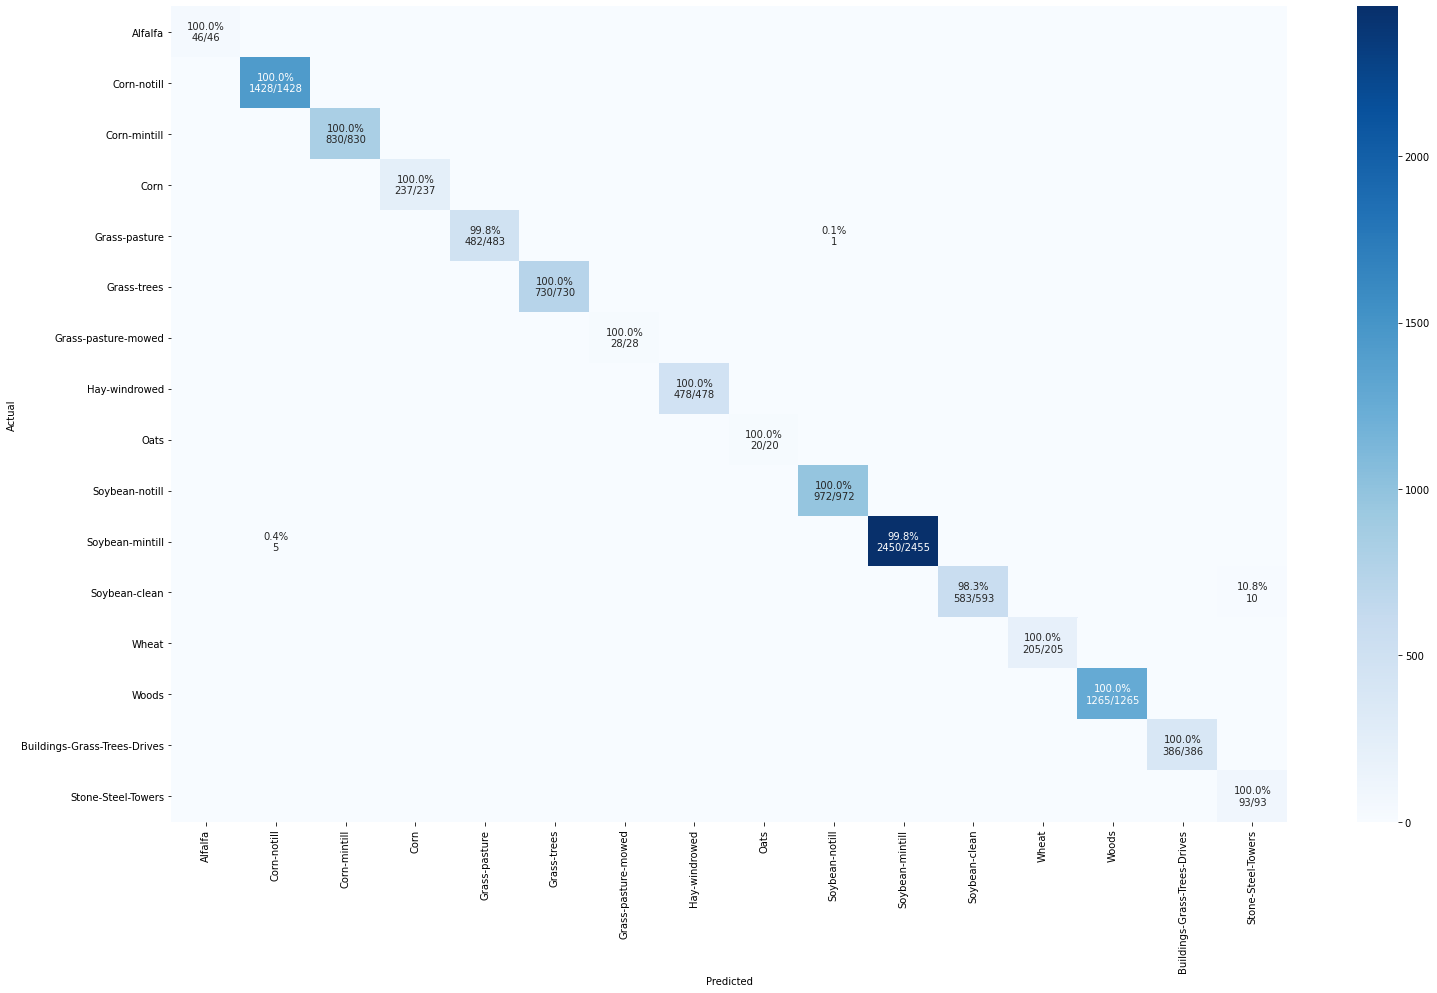


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        46
                 Corn-notill       1.00      1.00      1.00      1433
                Corn-mintill       1.00      1.00      1.00       830
                        Corn       1.00      1.00      1.00       237
               Grass-pasture       1.00      1.00      1.00       482
                 Grass-trees       1.00      1.00      1.00       730
         Grass-pasture-mowed       1.00      1.00      1.00        28
               Hay-windrowed       1.00      1.00      1.00       478
                        Oats       1.00      1.00      1.00        20
              Soybean-notill       1.00      1.00      1.00       973
             Soybean-mintill       1.00      1.00      1.00      2450
               Soybean-clean       0.98      1.00      0.99       583
                       Wheat       1.00      1.00      1.00   

In [ ]:
hybrid_sn(number_of_components = 20, window_size = 15, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

Load dataset

X shape : (145, 145, 200)
y shape : (145, 145)



Apply PCA

temp_X shape : (21025, 200)
X shape after applying PCA dimensionality reduction technique : (145, 145, 20)



Create smaller image cuboids

The shape of X after zero padding : (161, 161, 20)
The shape of y after zero padding : (161, 161)
Classes available for classification after removing class 0 : [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
New Class labels starting from 0 :  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
The shape of X_cuboids : (10249, 17, 17, 20)
The shape of y_cuboids_labels : (10249,)



Number of elements present in each class of y: {0.0: 46, 1.0: 1428, 2.0: 830, 3.0: 237, 4.0: 483, 5.0: 730, 6.0: 28, 7.0: 478, 8.0: 20, 9.0: 972, 10.0: 2455, 11.0: 593, 12.0: 205, 13.0: 1265, 14.0: 386, 15.0: 93}



Splitting Dataset

X_train shape : (6866, 17, 17, 20)
y_train shape : (6866,)
X_test shape  : (3383, 17, 17, 20)
y_test shape  : (3383,)
Number of eleme

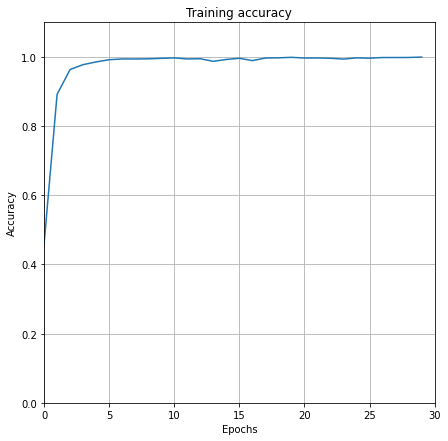




Test hybrid_sn 

y_test shape after applying one hot encoding : (3383, 16)

Time taken for predicting test set : 0:00:15.303921



Testing set CNN report

Number of classes predicted : 16

Confusion matrix : 



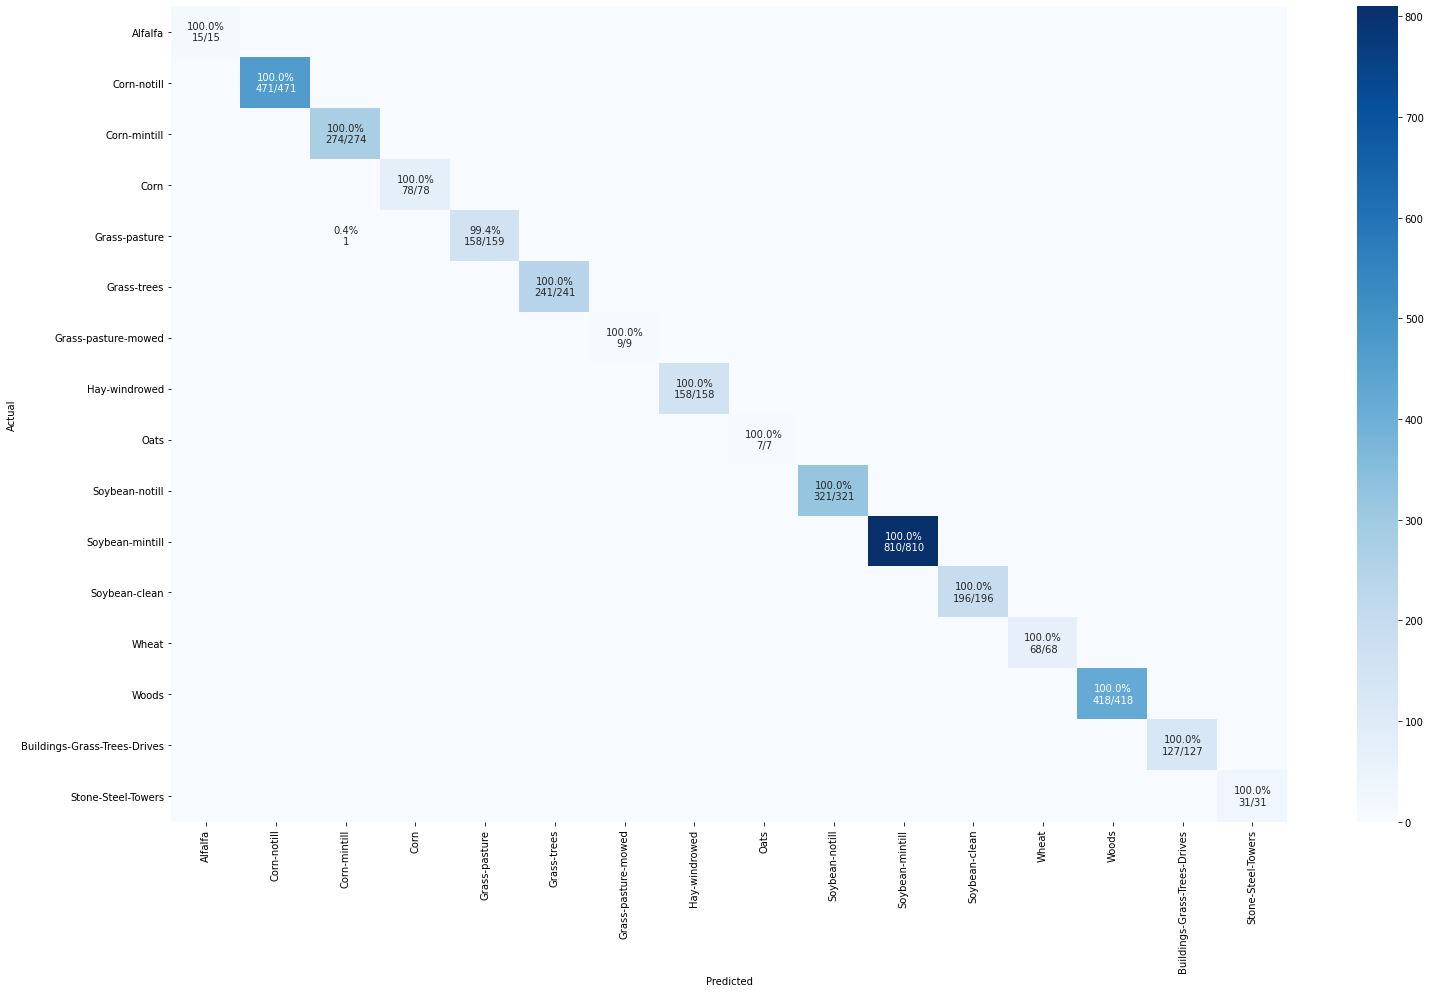


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        15
                 Corn-notill       1.00      1.00      1.00       471
                Corn-mintill       1.00      1.00      1.00       275
                        Corn       1.00      1.00      1.00        78
               Grass-pasture       0.99      1.00      1.00       158
                 Grass-trees       1.00      1.00      1.00       241
         Grass-pasture-mowed       1.00      1.00      1.00         9
               Hay-windrowed       1.00      1.00      1.00       158
                        Oats       1.00      1.00      1.00         7
              Soybean-notill       1.00      1.00      1.00       321
             Soybean-mintill       1.00      1.00      1.00       810
               Soybean-clean       1.00      1.00      1.00       196
                       Wheat       1.00      1.00      1.00   


Time taken for predicting entire image : 0:08:50.657928





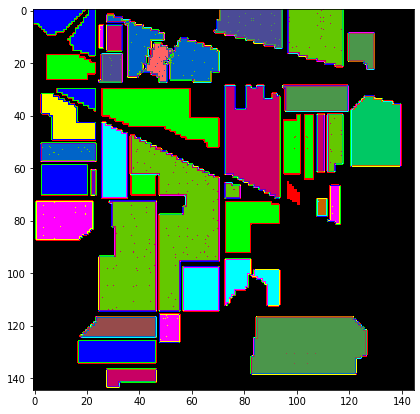

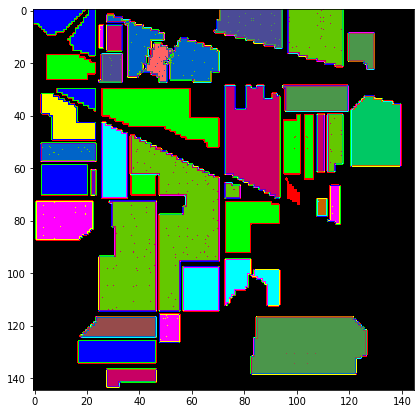




hybrid_sn report for predicting entire dataset

Number of classes predicted : 16

Confusion matrix : 



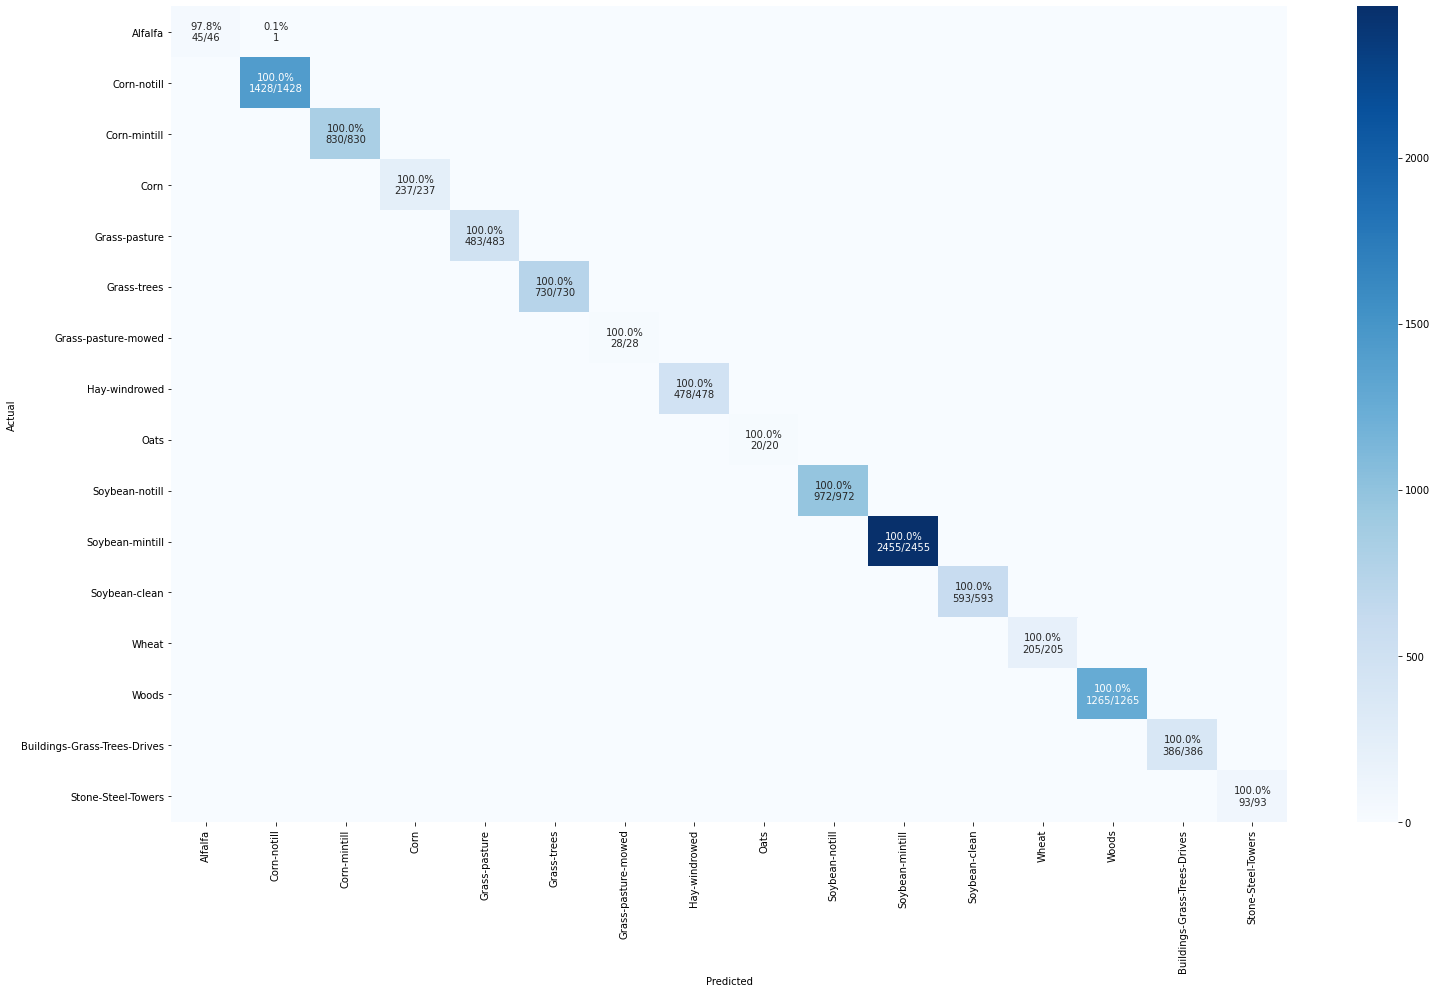


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       0.98      1.00      0.99        45
                 Corn-notill       1.00      1.00      1.00      1429
                Corn-mintill       1.00      1.00      1.00       830
                        Corn       1.00      1.00      1.00       237
               Grass-pasture       1.00      1.00      1.00       483
                 Grass-trees       1.00      1.00      1.00       730
         Grass-pasture-mowed       1.00      1.00      1.00        28
               Hay-windrowed       1.00      1.00      1.00       478
                        Oats       1.00      1.00      1.00        20
              Soybean-notill       1.00      1.00      1.00       972
             Soybean-mintill       1.00      1.00      1.00      2455
               Soybean-clean       1.00      1.00      1.00       593
                       Wheat       1.00      1.00      1.00   

In [ ]:
hybrid_sn(number_of_components = 20, window_size = 17, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

Load dataset

X shape : (145, 145, 200)
y shape : (145, 145)



Apply PCA

temp_X shape : (21025, 200)
X shape after applying PCA dimensionality reduction technique : (145, 145, 20)



Create smaller image cuboids

The shape of X after zero padding : (163, 163, 20)
The shape of y after zero padding : (163, 163)
Classes available for classification after removing class 0 : [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
New Class labels starting from 0 :  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
The shape of X_cuboids : (10249, 19, 19, 20)
The shape of y_cuboids_labels : (10249,)



Number of elements present in each class of y: {0.0: 46, 1.0: 1428, 2.0: 830, 3.0: 237, 4.0: 483, 5.0: 730, 6.0: 28, 7.0: 478, 8.0: 20, 9.0: 972, 10.0: 2455, 11.0: 593, 12.0: 205, 13.0: 1265, 14.0: 386, 15.0: 93}



Splitting Dataset

X_train shape : (6866, 19, 19, 20)
y_train shape : (6866,)
X_test shape  : (3383, 19, 19, 20)
y_test shape  : (3383,)
Number of eleme

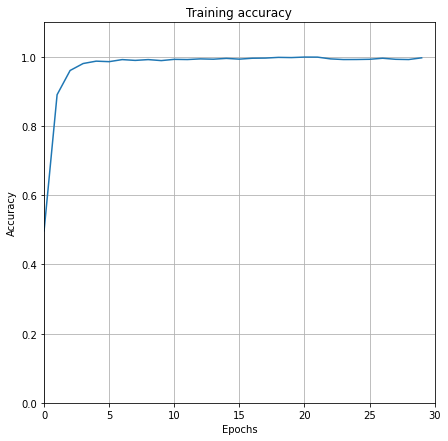




Test hybrid_sn 

y_test shape after applying one hot encoding : (3383, 16)

Time taken for predicting test set : 0:00:18.834880



Testing set CNN report

Number of classes predicted : 16

Confusion matrix : 



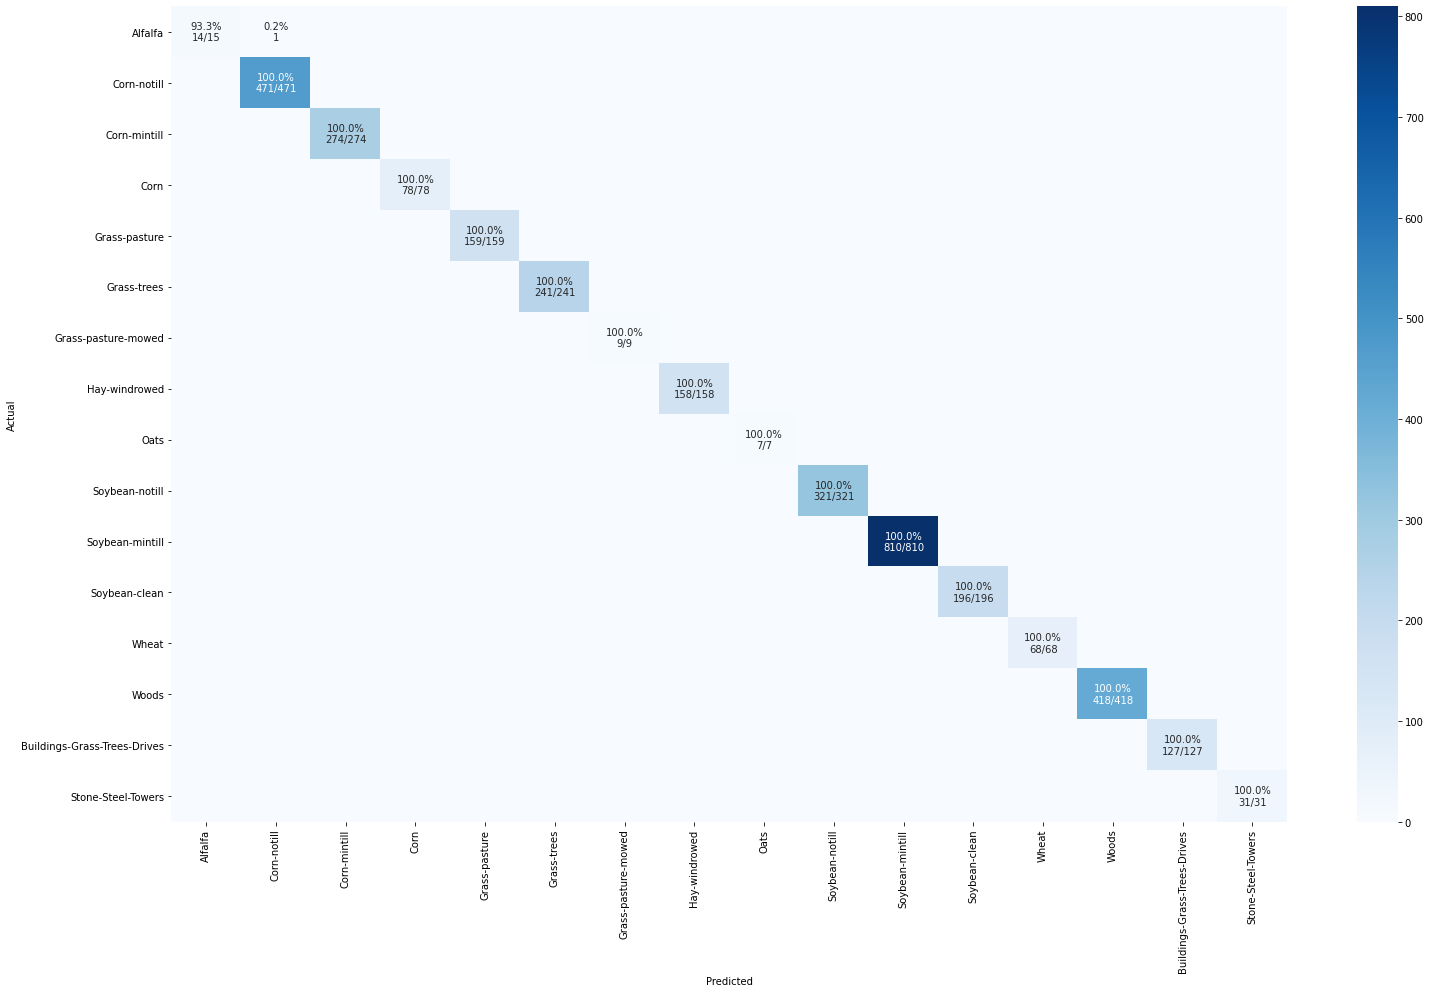


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       0.93      1.00      0.97        14
                 Corn-notill       1.00      1.00      1.00       472
                Corn-mintill       1.00      1.00      1.00       274
                        Corn       1.00      1.00      1.00        78
               Grass-pasture       1.00      1.00      1.00       159
                 Grass-trees       1.00      1.00      1.00       241
         Grass-pasture-mowed       1.00      1.00      1.00         9
               Hay-windrowed       1.00      1.00      1.00       158
                        Oats       1.00      1.00      1.00         7
              Soybean-notill       1.00      1.00      1.00       321
             Soybean-mintill       1.00      1.00      1.00       810
               Soybean-clean       1.00      1.00      1.00       196
                       Wheat       1.00      1.00      1.00   


Time taken for predicting entire image : 0:09:21.001531





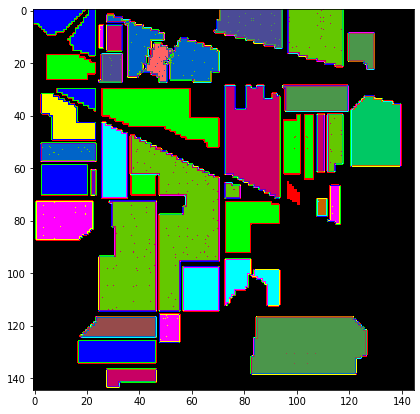

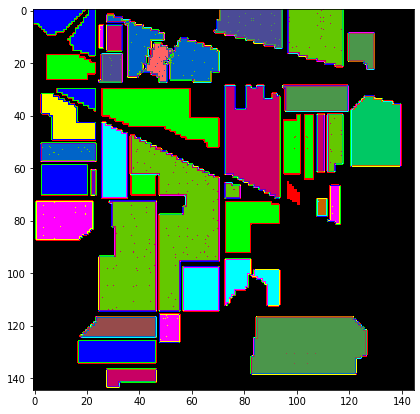




hybrid_sn report for predicting entire dataset

Number of classes predicted : 16

Confusion matrix : 



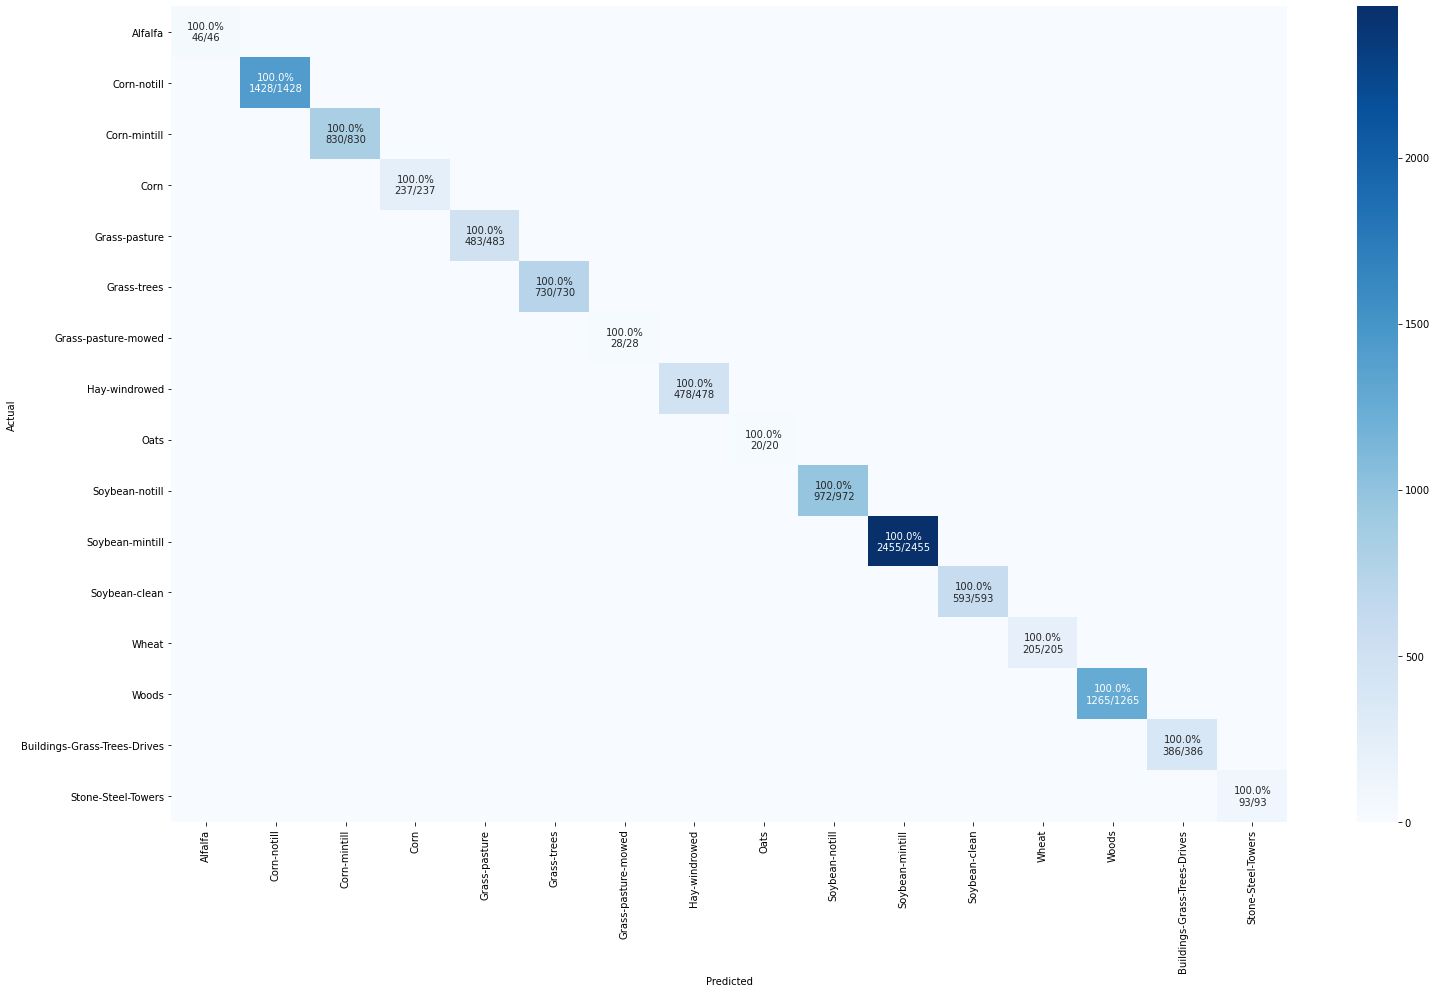


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        46
                 Corn-notill       1.00      1.00      1.00      1428
                Corn-mintill       1.00      1.00      1.00       830
                        Corn       1.00      1.00      1.00       237
               Grass-pasture       1.00      1.00      1.00       483
                 Grass-trees       1.00      1.00      1.00       730
         Grass-pasture-mowed       1.00      1.00      1.00        28
               Hay-windrowed       1.00      1.00      1.00       478
                        Oats       1.00      1.00      1.00        20
              Soybean-notill       1.00      1.00      1.00       972
             Soybean-mintill       1.00      1.00      1.00      2455
               Soybean-clean       1.00      1.00      1.00       593
                       Wheat       1.00      1.00      1.00   

In [ ]:
hybrid_sn(number_of_components = 20, window_size = 19, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

Load dataset

X shape : (145, 145, 200)
y shape : (145, 145)



Apply PCA

temp_X shape : (21025, 200)
X shape after applying PCA dimensionality reduction technique : (145, 145, 20)



Create smaller image cuboids

The shape of X after zero padding : (165, 165, 20)
The shape of y after zero padding : (165, 165)
Classes available for classification after removing class 0 : [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
New Class labels starting from 0 :  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
The shape of X_cuboids : (10249, 21, 21, 20)
The shape of y_cuboids_labels : (10249,)



Number of elements present in each class of y: {0.0: 46, 1.0: 1428, 2.0: 830, 3.0: 237, 4.0: 483, 5.0: 730, 6.0: 28, 7.0: 478, 8.0: 20, 9.0: 972, 10.0: 2455, 11.0: 593, 12.0: 205, 13.0: 1265, 14.0: 386, 15.0: 93}



Splitting Dataset

X_train shape : (6866, 21, 21, 20)
y_train shape : (6866,)
X_test shape  : (3383, 21, 21, 20)
y_test shape  : (3383,)
Number of eleme

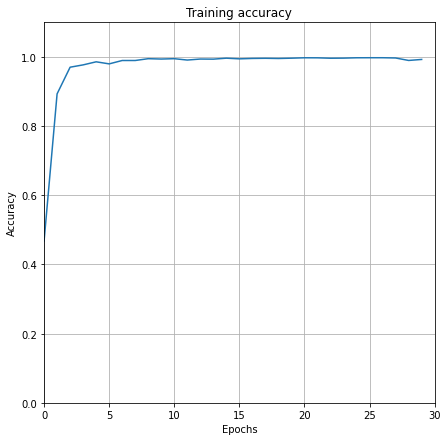




Test hybrid_sn 

y_test shape after applying one hot encoding : (3383, 16)

Time taken for predicting test set : 0:00:25.068127



Testing set CNN report

Number of classes predicted : 16

Confusion matrix : 



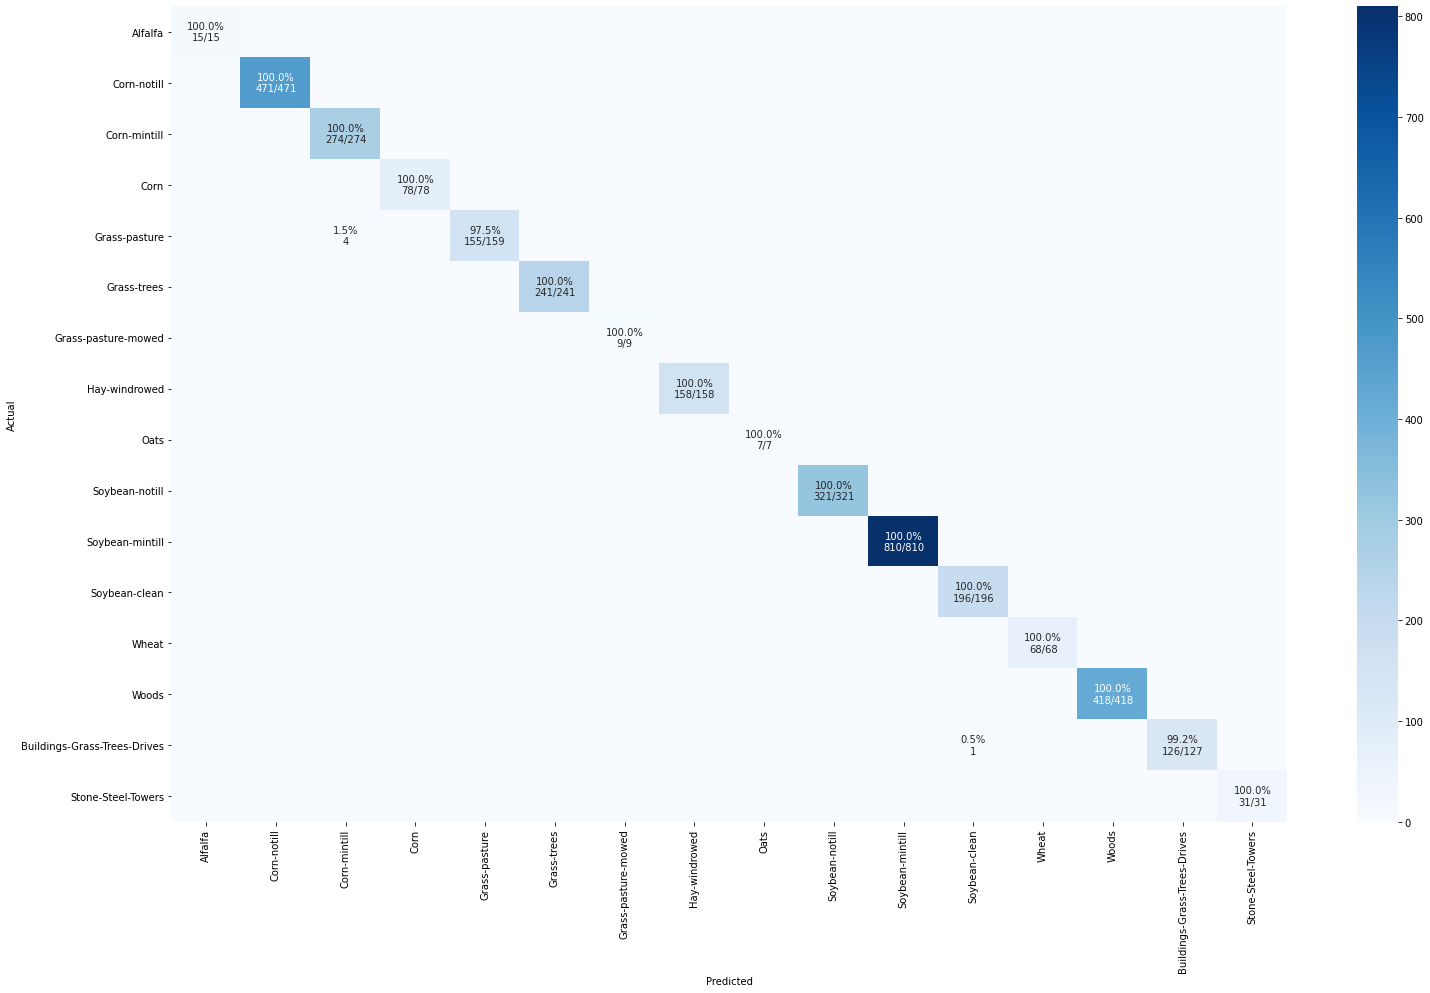


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        15
                 Corn-notill       1.00      1.00      1.00       471
                Corn-mintill       1.00      0.99      0.99       278
                        Corn       1.00      1.00      1.00        78
               Grass-pasture       0.97      1.00      0.99       155
                 Grass-trees       1.00      1.00      1.00       241
         Grass-pasture-mowed       1.00      1.00      1.00         9
               Hay-windrowed       1.00      1.00      1.00       158
                        Oats       1.00      1.00      1.00         7
              Soybean-notill       1.00      1.00      1.00       321
             Soybean-mintill       1.00      1.00      1.00       810
               Soybean-clean       1.00      0.99      1.00       197
                       Wheat       1.00      1.00      1.00   


Time taken for predicting entire image : 0:09:32.361101





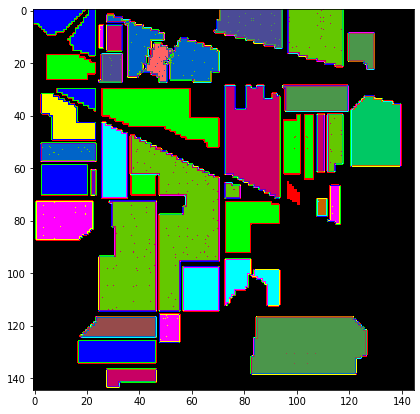

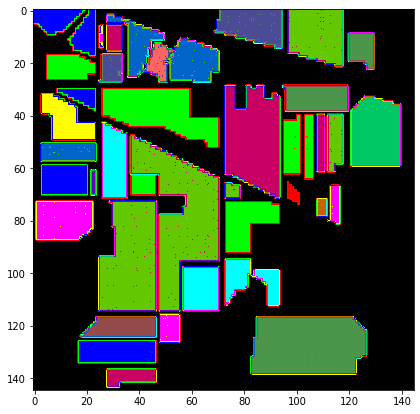




hybrid_sn report for predicting entire dataset

Number of classes predicted : 16

Confusion matrix : 



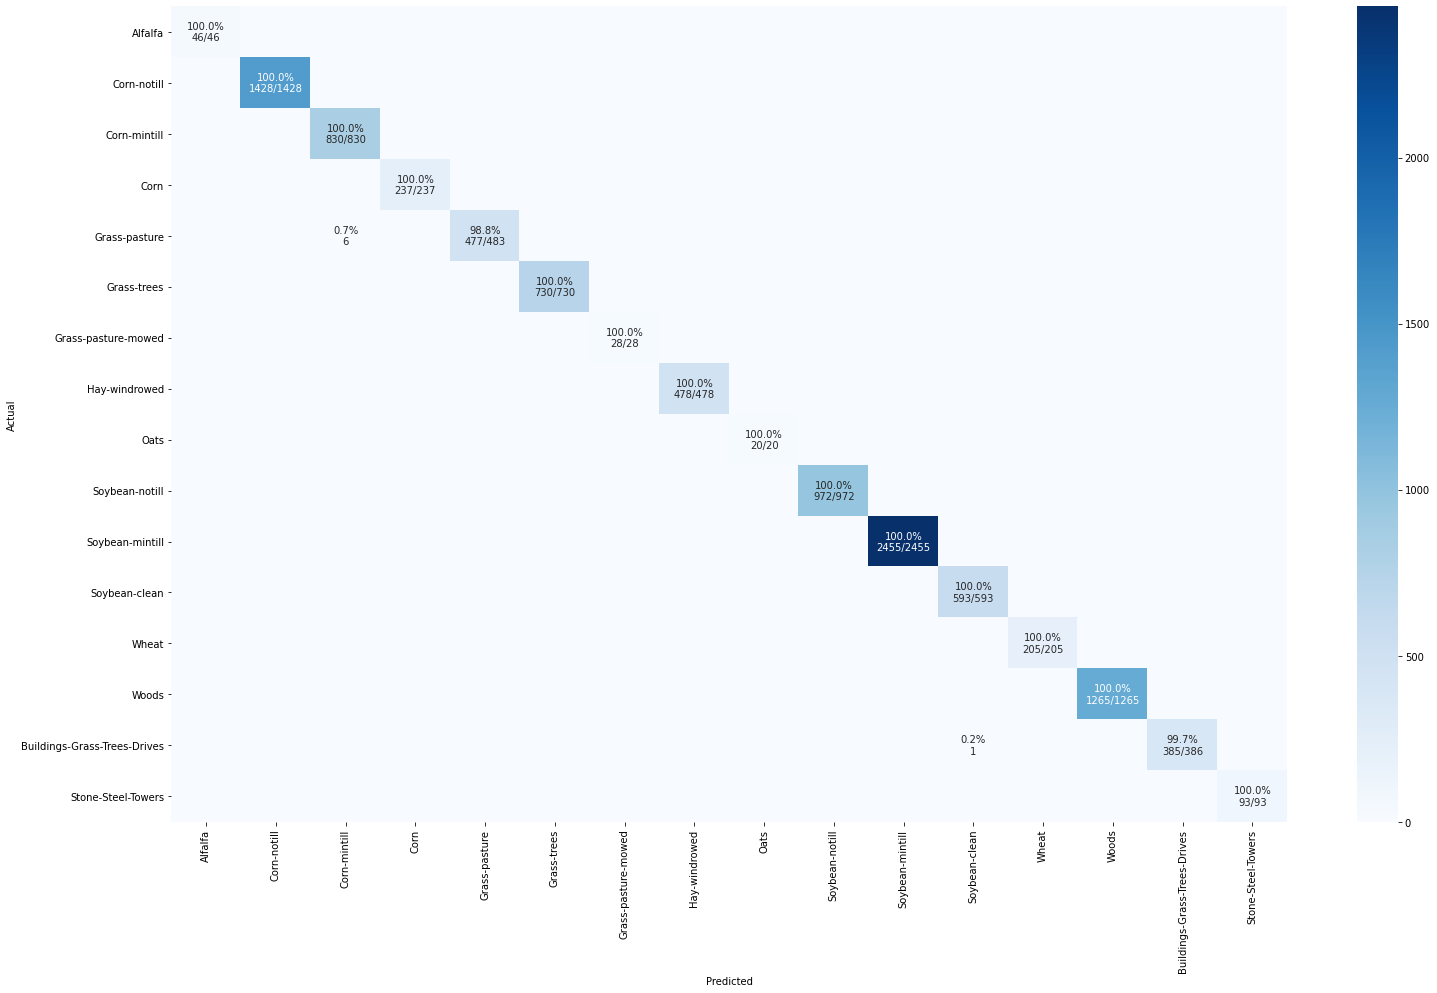


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        46
                 Corn-notill       1.00      1.00      1.00      1428
                Corn-mintill       1.00      0.99      1.00       836
                        Corn       1.00      1.00      1.00       237
               Grass-pasture       0.99      1.00      0.99       477
                 Grass-trees       1.00      1.00      1.00       730
         Grass-pasture-mowed       1.00      1.00      1.00        28
               Hay-windrowed       1.00      1.00      1.00       478
                        Oats       1.00      1.00      1.00        20
              Soybean-notill       1.00      1.00      1.00       972
             Soybean-mintill       1.00      1.00      1.00      2455
               Soybean-clean       1.00      1.00      1.00       594
                       Wheat       1.00      1.00      1.00   

In [ ]:
hybrid_sn(number_of_components = 20, window_size = 21, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

Load dataset

X shape : (145, 145, 200)
y shape : (145, 145)



Apply PCA

temp_X shape : (21025, 200)
X shape after applying PCA dimensionality reduction technique : (145, 145, 20)



Create smaller image cuboids

The shape of X after zero padding : (167, 167, 20)
The shape of y after zero padding : (167, 167)
Classes available for classification after removing class 0 : [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
New Class labels starting from 0 :  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
The shape of X_cuboids : (10249, 23, 23, 20)
The shape of y_cuboids_labels : (10249,)



Number of elements present in each class of y: {0.0: 46, 1.0: 1428, 2.0: 830, 3.0: 237, 4.0: 483, 5.0: 730, 6.0: 28, 7.0: 478, 8.0: 20, 9.0: 972, 10.0: 2455, 11.0: 593, 12.0: 205, 13.0: 1265, 14.0: 386, 15.0: 93}



Splitting Dataset

X_train shape : (6866, 23, 23, 20)
y_train shape : (6866,)
X_test shape  : (3383, 23, 23, 20)
y_test shape  : (3383,)
Number of eleme

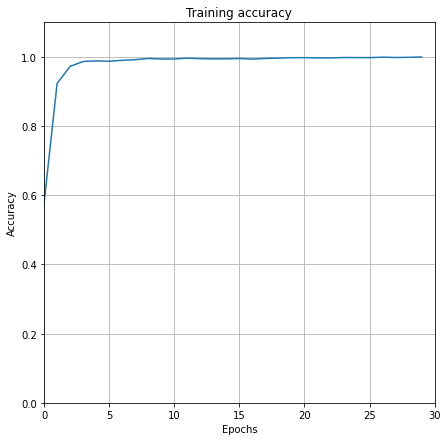




Test hybrid_sn 

y_test shape after applying one hot encoding : (3383, 16)

Time taken for predicting test set : 0:00:30.018183



Testing set CNN report

Number of classes predicted : 16

Confusion matrix : 



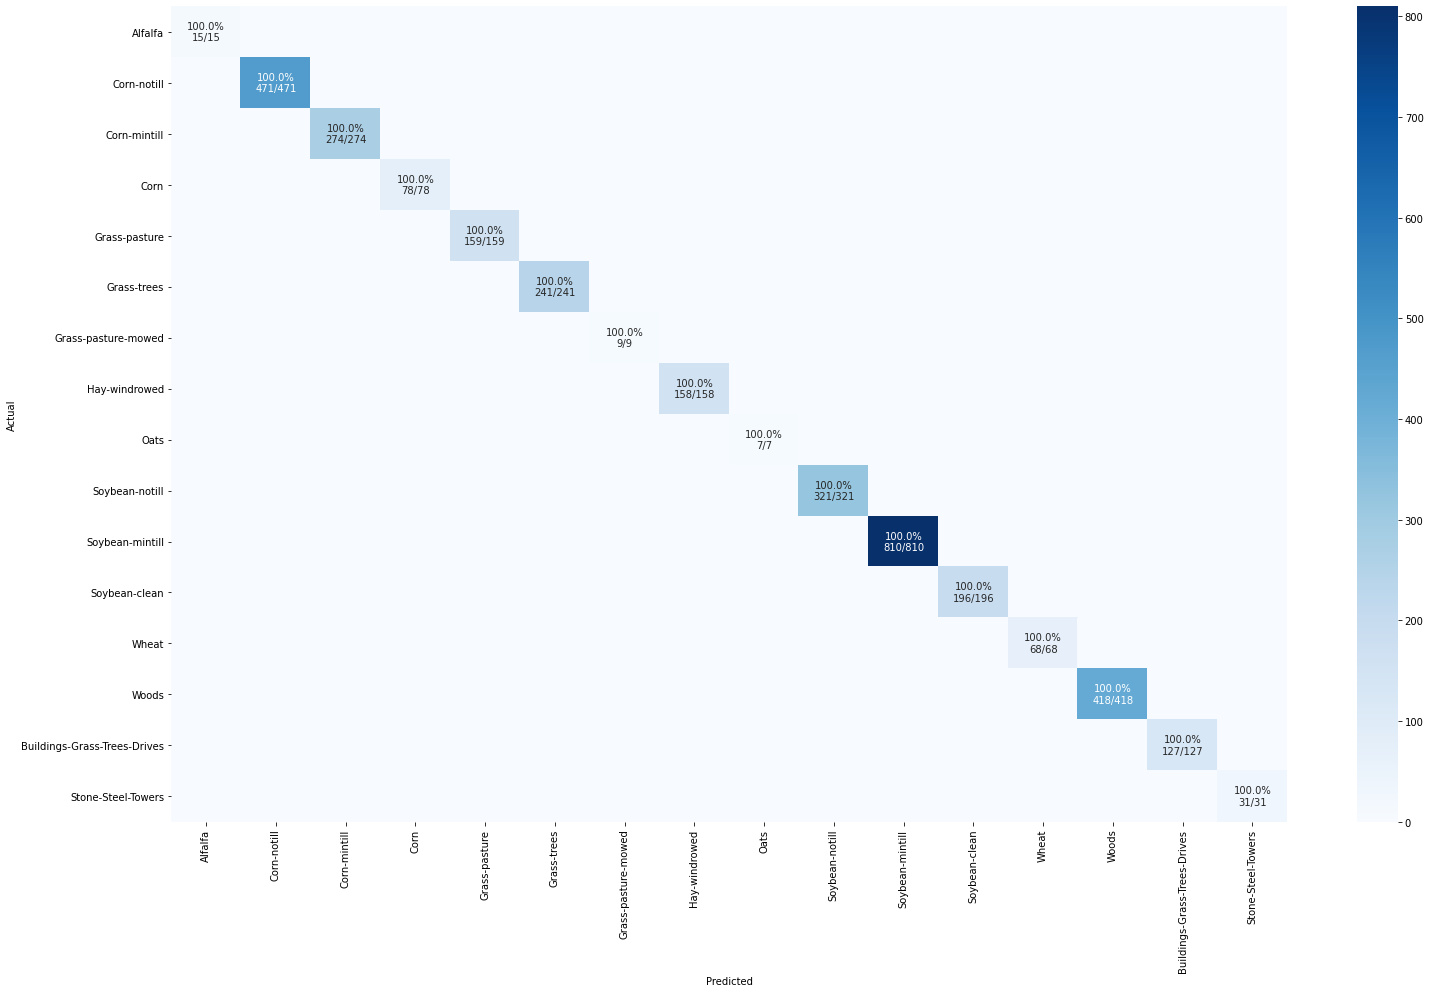


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        15
                 Corn-notill       1.00      1.00      1.00       471
                Corn-mintill       1.00      1.00      1.00       274
                        Corn       1.00      1.00      1.00        78
               Grass-pasture       1.00      1.00      1.00       159
                 Grass-trees       1.00      1.00      1.00       241
         Grass-pasture-mowed       1.00      1.00      1.00         9
               Hay-windrowed       1.00      1.00      1.00       158
                        Oats       1.00      1.00      1.00         7
              Soybean-notill       1.00      1.00      1.00       321
             Soybean-mintill       1.00      1.00      1.00       810
               Soybean-clean       1.00      1.00      1.00       196
                       Wheat       1.00      1.00      1.00   


Time taken for predicting entire image : 0:08:52.457482





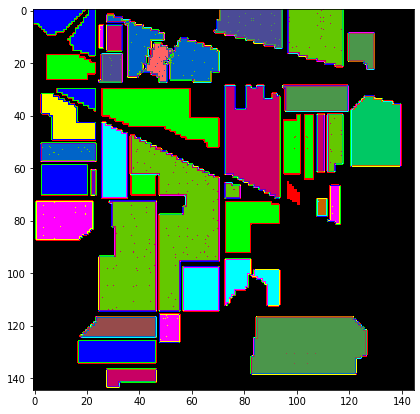

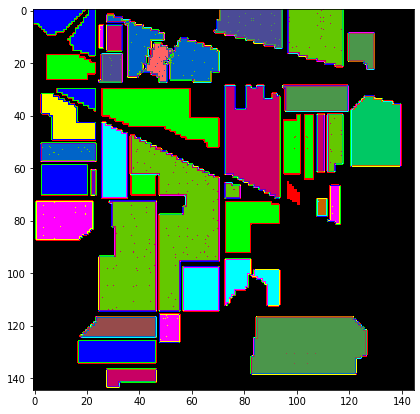




hybrid_sn report for predicting entire dataset

Number of classes predicted : 16

Confusion matrix : 



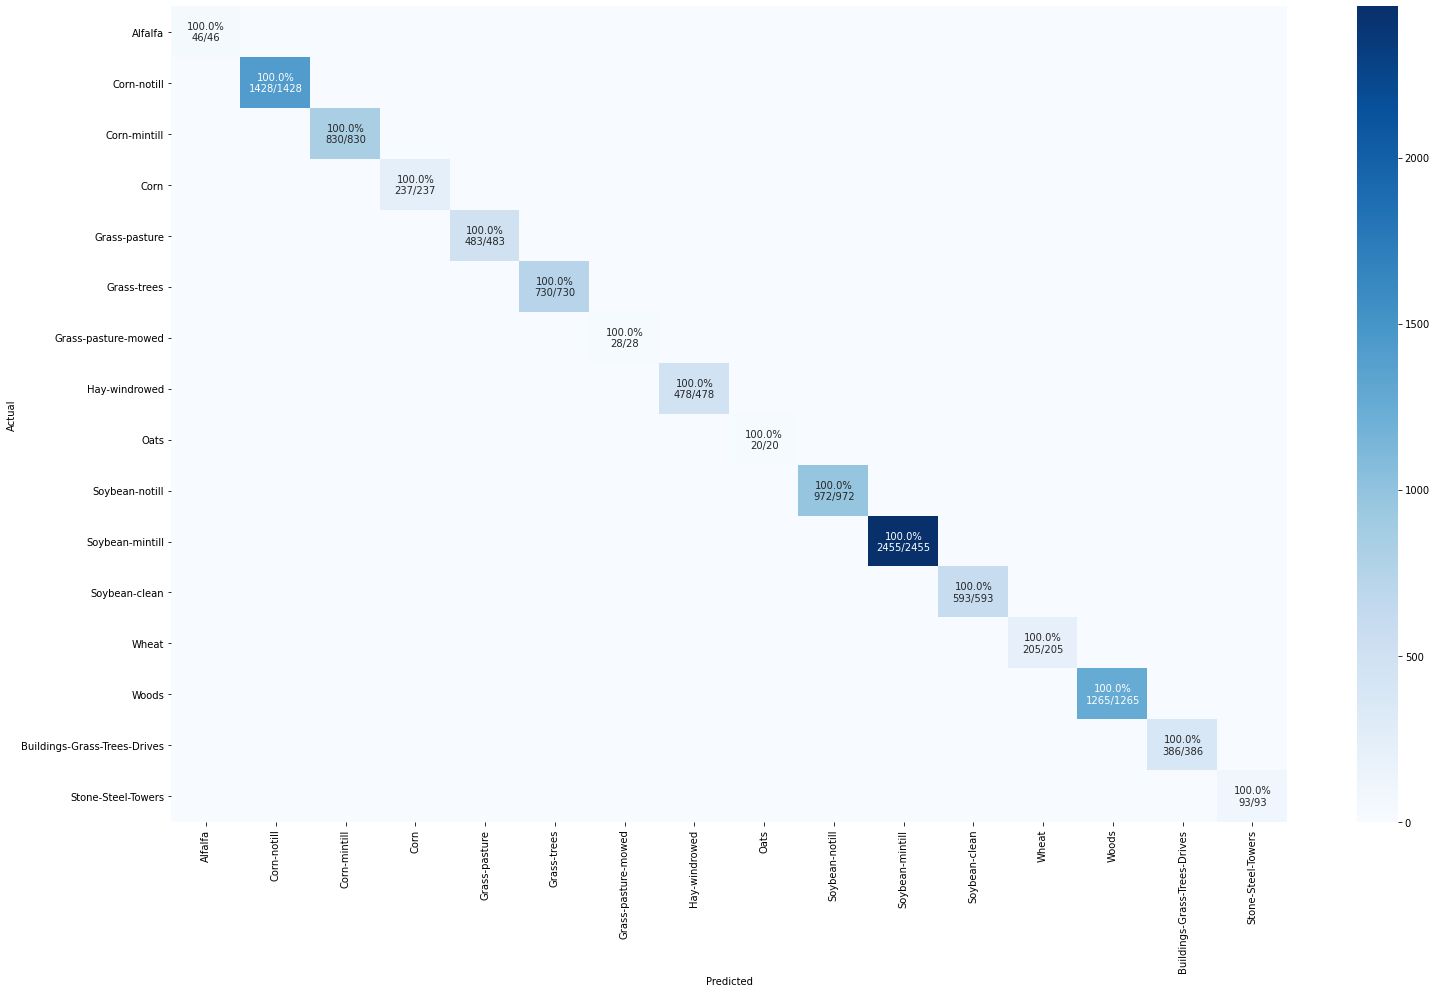


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        46
                 Corn-notill       1.00      1.00      1.00      1428
                Corn-mintill       1.00      1.00      1.00       830
                        Corn       1.00      1.00      1.00       237
               Grass-pasture       1.00      1.00      1.00       483
                 Grass-trees       1.00      1.00      1.00       730
         Grass-pasture-mowed       1.00      1.00      1.00        28
               Hay-windrowed       1.00      1.00      1.00       478
                        Oats       1.00      1.00      1.00        20
              Soybean-notill       1.00      1.00      1.00       972
             Soybean-mintill       1.00      1.00      1.00      2455
               Soybean-clean       1.00      1.00      1.00       593
                       Wheat       1.00      1.00      1.00   

In [ ]:
hybrid_sn(number_of_components = 20, window_size = 23, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)

Load dataset

X shape : (145, 145, 200)
y shape : (145, 145)



Apply PCA

temp_X shape : (21025, 200)
X shape after applying PCA dimensionality reduction technique : (145, 145, 20)



Create smaller image cuboids

The shape of X after zero padding : (169, 169, 20)
The shape of y after zero padding : (169, 169)
Classes available for classification after removing class 0 : [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
New Class labels starting from 0 :  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
The shape of X_cuboids : (10249, 25, 25, 20)
The shape of y_cuboids_labels : (10249,)



Number of elements present in each class of y: {0.0: 46, 1.0: 1428, 2.0: 830, 3.0: 237, 4.0: 483, 5.0: 730, 6.0: 28, 7.0: 478, 8.0: 20, 9.0: 972, 10.0: 2455, 11.0: 593, 12.0: 205, 13.0: 1265, 14.0: 386, 15.0: 93}



Splitting Dataset

X_train shape : (6866, 25, 25, 20)
y_train shape : (6866,)
X_test shape  : (3383, 25, 25, 20)
y_test shape  : (3383,)
Number of eleme

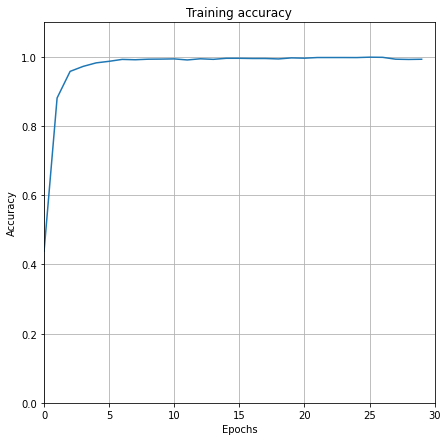




Test hybrid_sn 

y_test shape after applying one hot encoding : (3383, 16)

Time taken for predicting test set : 0:00:36.676352



Testing set CNN report

Number of classes predicted : 16

Confusion matrix : 



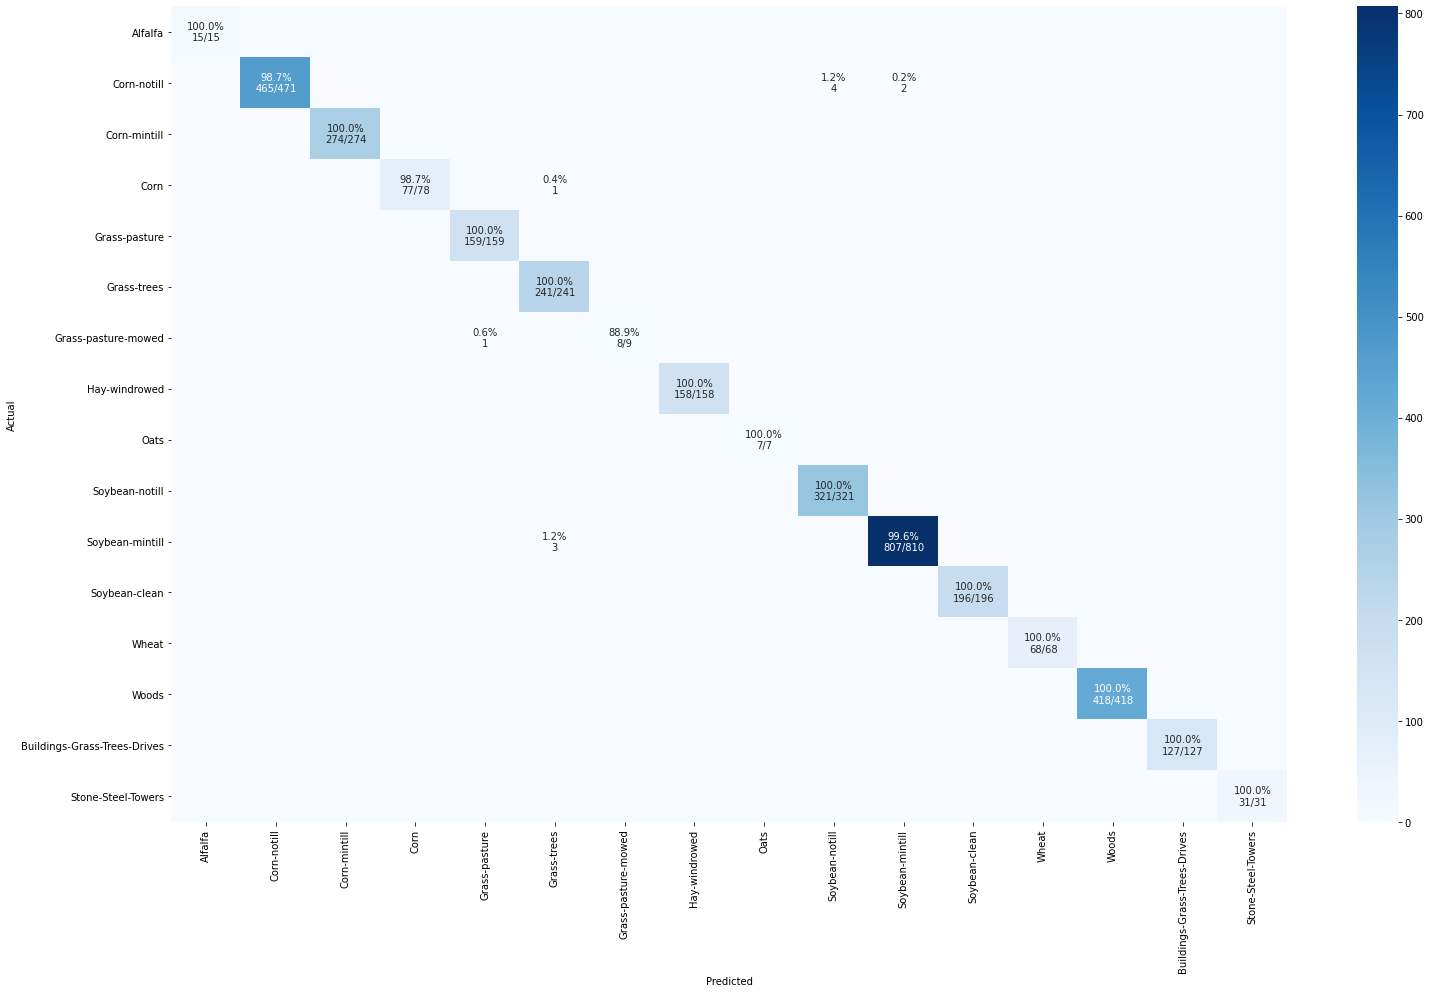


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        15
                 Corn-notill       0.99      1.00      0.99       465
                Corn-mintill       1.00      1.00      1.00       274
                        Corn       0.99      1.00      0.99        77
               Grass-pasture       1.00      0.99      1.00       160
                 Grass-trees       1.00      0.98      0.99       245
         Grass-pasture-mowed       0.89      1.00      0.94         8
               Hay-windrowed       1.00      1.00      1.00       158
                        Oats       1.00      1.00      1.00         7
              Soybean-notill       1.00      0.99      0.99       325
             Soybean-mintill       1.00      1.00      1.00       809
               Soybean-clean       1.00      1.00      1.00       196
                       Wheat       1.00      1.00      1.00   


Time taken for predicting entire image : 0:09:04.135914





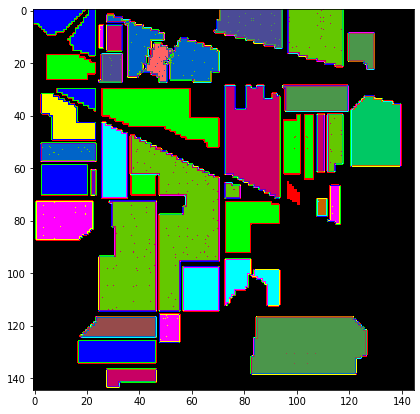

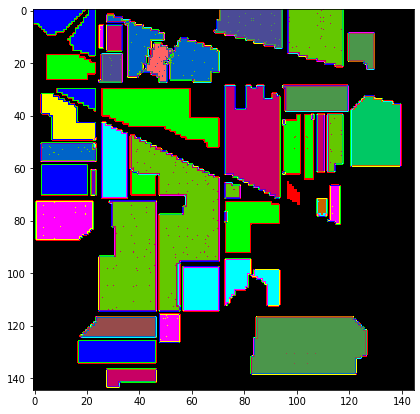




hybrid_sn report for predicting entire dataset

Number of classes predicted : 16

Confusion matrix : 



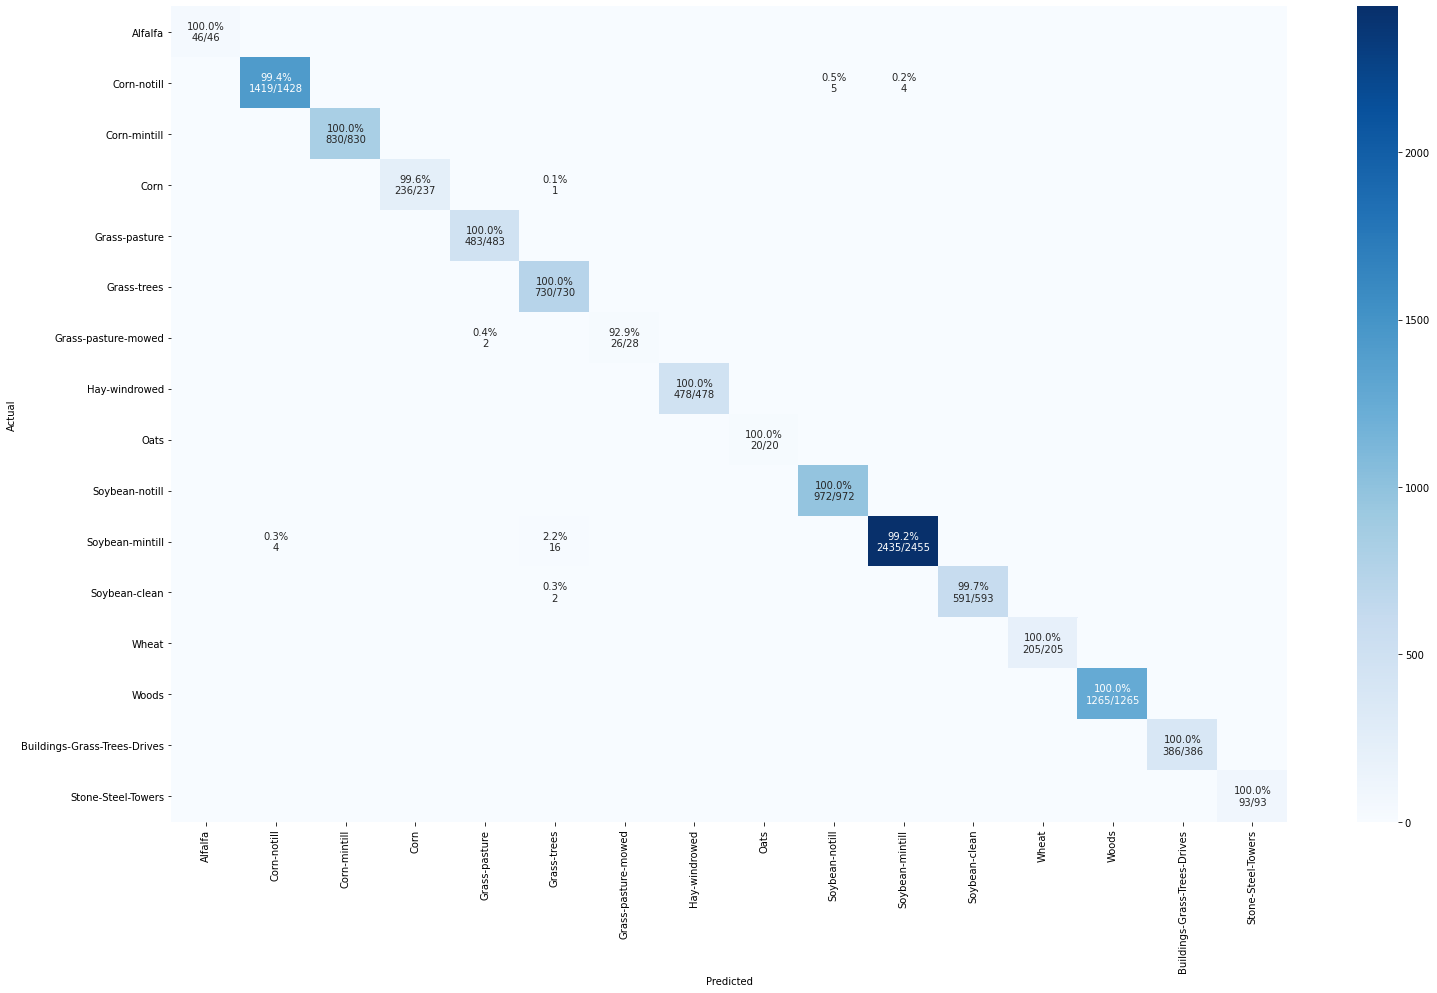


Classification report : 

                              precision    recall  f1-score   support

                     Alfalfa       1.00      1.00      1.00        46
                 Corn-notill       0.99      1.00      1.00      1423
                Corn-mintill       1.00      1.00      1.00       830
                        Corn       1.00      1.00      1.00       236
               Grass-pasture       1.00      1.00      1.00       485
                 Grass-trees       1.00      0.97      0.99       749
         Grass-pasture-mowed       0.93      1.00      0.96        26
               Hay-windrowed       1.00      1.00      1.00       478
                        Oats       1.00      1.00      1.00        20
              Soybean-notill       1.00      0.99      1.00       977
             Soybean-mintill       0.99      1.00      1.00      2439
               Soybean-clean       1.00      1.00      1.00       591
                       Wheat       1.00      1.00      1.00   

In [47]:
hybrid_sn(number_of_components = 20, window_size = 25, labelling_type="center", test_ratio = 0.33 ,dropout = 0.40, epoch = 30, size =  128)